In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')


In [2]:
# uncomment to disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[]


In [3]:
def compare_to_ref(ref_traj, trajs, weights, *args, method = None, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
#     weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.02)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.002)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[p,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
#             if i * ncol + j in restrained_patches and method != 'unbiased':
#                 for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
#                     pf(ax[i,j],0, color='C3')
#                 ax[i,j].spines['bottom'].set_color('y')
#                 ax[i,j].spines['top'].set_color('y') 
#                 ax[i,j].spines['right'].set_color('y')
#                 ax[i,j].spines['left'].set_color('y')
#                 ax[i,j].spines['left'].set_linewidth(2)
#                 ax[i,j].spines['top'].set_linewidth(2)
#                 ax[i,j].spines['right'].set_linewidth(2)
#                 ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
    plt.tight_layout()


## Reference Model

In [4]:
# Loading trajectory
results=pd.read_csv('Resultscounty.txt',header=None,sep='\t')
results.columns=['ID','time','county','S','E','A','I','R','P','D']
# results=pd.merge(results,parameters,on='ID')
results.sort_values(['ID','time'],ascending=True,inplace=True)
dictionary=pd.read_csv('countydictionary.csv')
dictionary.columns=['COUNTY CODE','COUNTY NAME','county']
results=pd.merge(results,dictionary,on='county')
# results=resultspatch[['time','COUNTY NAME','S','E','A','I','R','P','D','beta','tauexposed','taupresymp','tauI','casefatalityrate','COUNTY CODE']]  
results=results[['ID','time','COUNTY NAME','S','E','A','I','R','P','D']]
results.loc[:,"S":"D"] = results.loc[:,"S":"D"].div(results.loc[:,"S":"D"].sum(axis =1), axis=0)
population =pd.read_csv('popCounty.txt',index_col=False,names=['ID','Population'],header=None,sep=' ')['Population'].tolist()
population_fraction = population/np.sum(population)
area =pd.read_csv('areaCounty.txt',index_col=False,names=['ID','Area'],header=None,sep=' ')['Area'].tolist()
# Getting number of patches
patches = np.unique(results['COUNTY NAME'].values)
M = len(patches)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


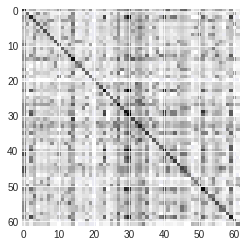

In [5]:
# load mobility matrix
networkCounty=pd.read_csv('networkCounty.txt',header=None,sep=' ')
networkCounty.columns=['ID','County','mobility_parameter']
# mobility_matrix = networkCounty.reset_index().groupby(['County'])['mobility_parameter'].apply(np.array).to_numpy()
# networkCounty = networkCounty[['ID','mobility_parameter']]
mobility_matrix = np.empty([0,M])
mobility_parameter_row = np.zeros(M)
for i,row in networkCounty.iterrows():
    mobility_parameter_row[networkCounty.loc[i, 'County']] = networkCounty.loc[i, 'mobility_parameter']
    if i < networkCounty.shape[0]-1:
        if networkCounty.loc[i+1, 'County'] == 0:
            mobility_matrix = np.append(mobility_matrix, [mobility_parameter_row], axis=0)
    #         print(mobility_parameter_row)
            mobility_parameter_row = np.zeros(M)
    else:
         mobility_matrix = np.append(mobility_matrix, [mobility_parameter_row], axis=0)

assert (np.shape(mobility_matrix)==(M,M))
mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
print (np.sum(mobility_matrix_norm, axis =1))
plt.imshow(np.log(mobility_matrix))

In [6]:
# Getting the time length
time_S = np.unique(results['time'].values)
Time_S = len(time_S)
# Getting number of trajectories
IDs = np.unique(results['ID'].values)
N = len(IDs)
np.set_printoptions(threshold=np.inf)
# Number of compartments
C = 7
ref_traj = np.empty((N, Time_S, M, C))
# start_time = 30
# end_time = 75
for n in IDs:
    for m, patch_name in enumerate(patches):
        ID = results.loc[results['ID'].isin([str(n)])]
        county = ID.loc[ID['COUNTY NAME'] == patch_name]
        traj_county = county[['S','E','A','I','R','P','D']].to_numpy()
        ref_traj[n,:,m,:] = traj_county
           
start_time = 0
end_time = 201  

Time = end_time - start_time
p = 0
# ref_traj = ref_traj[:, start_time:end_time,:,:]
## Combining P and D compartments into R
ref_traj[p,:,:,4] +=  ref_traj[p,:,:,5] + ref_traj[p,:,:,6]
ref_traj = ref_traj[p,:,:,:5]
# REF=ref_traj

# ref_traj = ref_traj[:,:,:]
ref_traj = ref_traj[np.newaxis,:,:,:]


In [7]:
# patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])
# plt.suptitle("Reference data", size=25, y=1.001)
# plt.tight_layout()
# plt.savefig('patch_quantile.png',dpi=400)
population[0:10]

[309381, 47462, 1455444, 196567, 77922, 78288, 130779, 87071, 48844, 81251]

In [8]:
## make a maxentep traj to compare 
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
eta = 1/2.6
alpha = 1/2.6
mu = 1/3.2
tmat.add_transition('E', 'A', 1/eta, 0)
tmat.add_transition('A', 'I', 1/alpha, 0)
tmat.add_transition('I', 'R', 1/mu, 0)

infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
timesteps = 202
model = maxentep.MetaModel(infect_fxn, timesteps, populations=np.array(population))

# starting fractions probabilities
start = np.zeros((M,C)) #anywhere
# assume starting from Bronx county
exposed_Bronx = 1/population[2]
start[2,0] = exposed_Bronx
# start[0,0] = 0.05
beta = 0.04
m_ref_traj = model(mobility_matrix_norm, tmat.value, start, beta)[0]
m_ref_traj = m_ref_traj[np.newaxis,70:201,:,:]

m_ref_traj.shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([1, 131, 62, 5])

Plotting 62 patches in a 7 x 9 grid


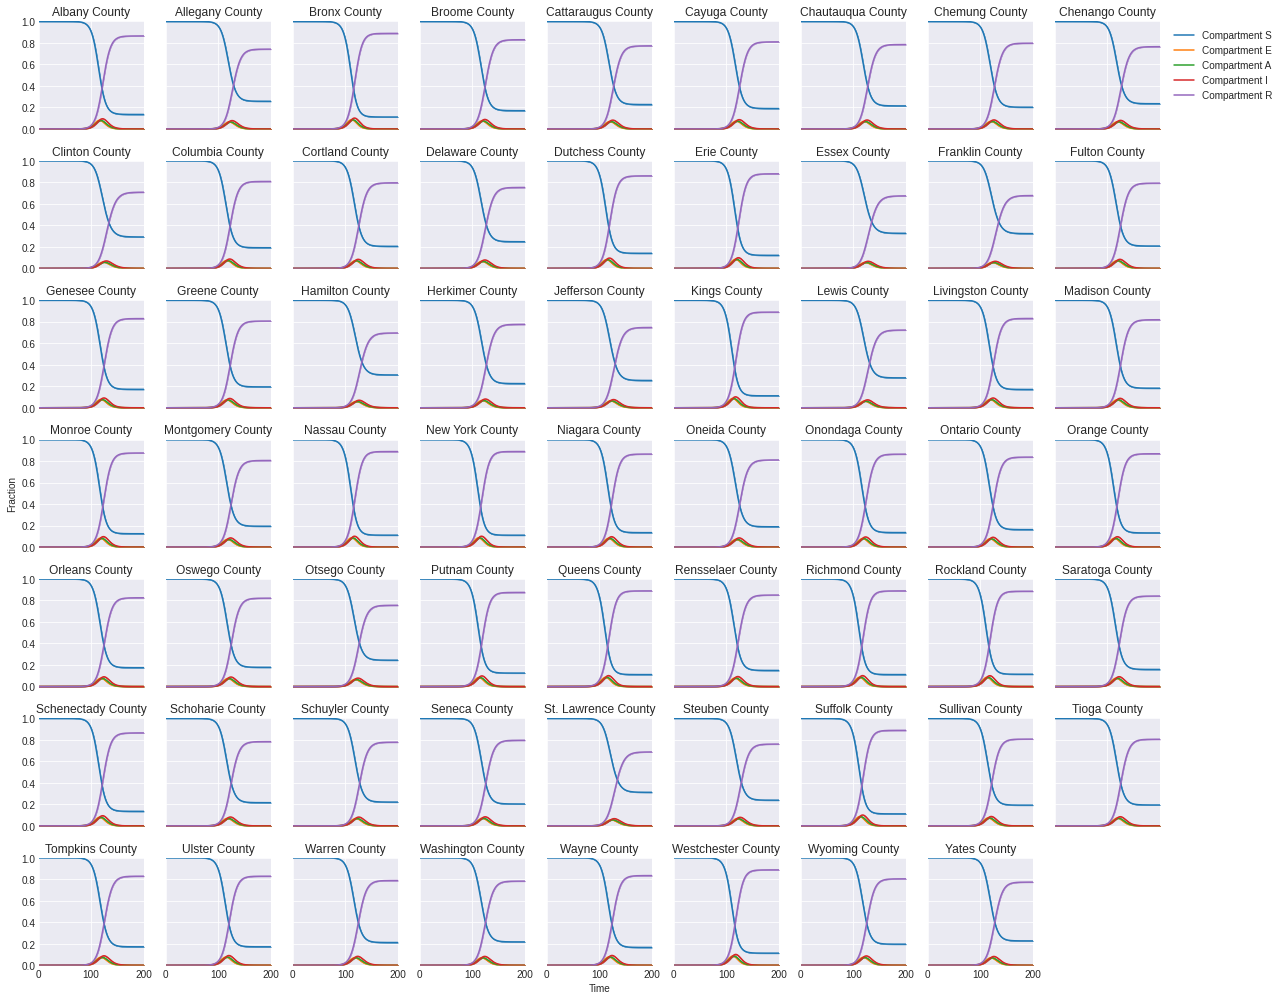

In [9]:
patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])
# plt.suptitle("Reference data", size=25, y=1.001)
# plt.tight_layout()
# plt.savefig('patch_quantile.png',dpi=400)

In [10]:
# ## make a maxentep traj to compare 
# # compartment parameters
# compartments = ['E', 'A', 'I', 'R']
# full_compartments = ['S'] + compartments
# infections_compartments = [1,2]
# C = len(compartments)
# tmat = maxentep.TransitionMatrix(compartments, [1,2])
eta = 1/2.6
alpha = 1/2.6
mu = 1/3.2
# tmat.add_transition('E', 'A', 1/eta, 0)
# tmat.add_transition('A', 'I', 1/alpha, 0)
# tmat.add_transition('I', 'R', 1/mu, 0)

# infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
# timesteps = 202
# model = maxentep.MetaModel(infect_fxn, timesteps, populations=np.array(population))

# # starting fractions probabilities
# start = np.zeros((M,C)) #anywhere
# # assume starting from Bronx county
# exposed_Bronx = 1/population[2]
# start[2,0] = exposed_Bronx
# # start[0,0] = 0.05
# beta = 0.04
# m_ref_traj = model(mobility_matrix_norm, tmat.value, start, beta)[0]
# ref_traj = m_ref_traj[np.newaxis,::,:]

# patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])

In [11]:
# compare_to_ref(ref_traj, m_ref_traj, weights=None, method='unbiased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)

In [12]:
# patch_quantile(m_ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])
# ref_traj = m_ref_traj
# total_pop = np.sum(population)
# R0 = 5
# t_max = np.log(total_pop)/mu/(R0-1)
# t_max

In [13]:
# Run this for creating frames for animations
import plotly.graph_objs as go
import plotly.figure_factory as ff 
process_traj = False
if process_traj == True:
    for t in range(T):
        infected_portion = [tf.round(ref_traj[0,t,i,3],2) for i in range(M)]
        zipcodes = dictionary['COUNTY CODE']
        fig = ff.create_choropleth(fips=zipcodes, 
                                   scope=['New York'],
                                   values=infected_portion,
                                   title='NY COVID-19 Infected Population Fraction by County',
                                   county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
                                   state_outline={'width': .5}
                                   )


        fig.update_layout(legend=dict(
            title='Infected Fraction',
            yanchor="top",
            y=0.95,
            xanchor="left",
            x=0.9,

        ))
        fig.add_annotation(dict(font=dict(color='black',size=30),
                                                x=0.4,
                                                y=0.12,
                                                showarrow=False,
                                                text="Day {}".format(t),
                                                textangle=0,
                                                xanchor='left',
                                                xref="paper",
                                                yref="paper"
                                                ))

        fig.layout.template = {'layout': {'font': {'family': 'Britannic Bold', 'size': 20}}}
        fig.write_image("NY_map//traj_" + str(t) +
                            ".png",width = 2048, height =1060)

# Run this for saving plots
if process_traj == True:
    for i in range(M):
        traj_quantile(ref_traj[:,:,i,:], names=['S','E','A','I','R','P','D'], add_legend=False, add_title = patches[i], plot_means=True)
        fig = plt.gcf()
        fig.set_size_inches(4, 4)
        #plt.savefig('{}.png'.format(patches[i]),dpi=400)
        plt.close()

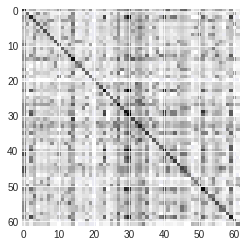

In [14]:
plt.imshow(np.log(mobility_matrix))

## Make restraints from reference trajectory

I R
Restraints are set in this time range: [75, 140]
122 0.0816586365722826 0.0588006956455831
94 0.005165575837676311 0.003531805063574361
87 0.0019039872365214292 0.0
129 0.07481373289207005 0.07614901336531418
101 0.013425803348763374 0.022738796701680067
101 0.028215566472549792 0.030051711761006617
136 0.6401875217196071 0.6266491724945383
94 0.010460800404405862 0.011853078037035374
122 0.32231591251235997 0.316944432254587
73 0.0004852572966266462 0.007395247782958423
108 0.031039903489468106 0.04686017969280814
87 0.0018161108096393117 0.0
136 0.05174621227463042 0.03527531443120726
80 0.0006525587574521262 0.0012641819580069189
94 0.004967163635325266 0.005158215241328456
87 0.0035872860919771293 0.0
129 0.5083859566531277 0.5054436780857289
94 0.009972104880739466 0.0
136 0.6573310152285641 0.6564779859385125
101 0.02712374622010243 0.04034510686448519
129 0.05729370642036754 0.06807442804967333
94 0.013005335330365375 0.009839602032157405
115 0.0960598945167599 0.11027990600

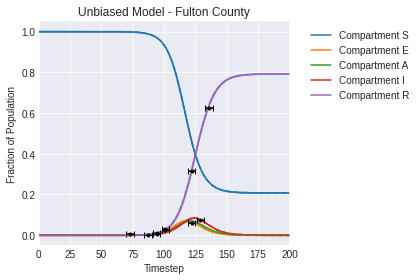

I R
[17 26 51]
17


In [15]:
compartments = ['E','A','I','R']
infections_compartments = [1,2]
full_compartments = ['S'] + compartments
npoints = 5
prior = maxentep.EmptyPrior()
# prior = maxentep.Laplace(0.1)
# p = 0

# restrained_patches = np.random.randint(M, size=number_of_restraint_patches)
number_of_restrained_patches = 3 
restrained_compartments = [3,4] #(infected patch and recovered)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
restrained_compartments_names = " ".join(restrained_compartments_names)
print (restrained_compartments_names)
number_of_restrained_compartments = len(restrained_compartments) 

restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)

restrained_patch = restrained_patches[0]

restraints, plot_fxns_list = maxentep.compartment_restrainer(restrained_patches,
                                                    restrained_compartments,ref_traj, prior,npoints=npoints,
                                                    noise=0.01,start_time=75, end_time=140)
maxentep.traj_quantile(ref_traj[:,:,restrained_patch,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[p,:,restrained_patch,:], linestyle='--')
plt.title('Unbiased Model - {}'.format(patches[restrained_patch]))
for i,pf in enumerate(plot_fxns_list[0]):
    pf(plt.gca(), 0)
plt.tight_layout()
plt.savefig('unbiased.png',dpi=200)
# plt.ylim(0,0.2)
# plt.xlim(0,75)
plt.show()
print (restrained_compartments_names)
print(restrained_patches)
print(restrained_patch)

## Restraining a sample SEAIRPD to reference

In [16]:
print(max(1/np.array(population)))
print(np.mean(1/np.array(population)))
print(np.var(1/np.array(population)))

0.00021222410865874363
1.6059567615649856e-05
7.469191736144403e-10


In [17]:
# compartment parameters
compartments = ['E','A','I','R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 3, 1)
tmat.add_transition('A', 'I', 3, 1)
tmat.add_transition('I', 'R', 4, 1)

print(tmat.value)
hyper_pram = maxentep.ParameterHypers()
hyper_pram.beta_low = 0.005
# hyper_pram.beta_low = 0.001
# hyper_pram.beta_high = 0.04
hyper_pram.beta_high = 0.06
hyper_pram.beta_var = 0.02
# hyper_pram.start_high = 2e-4
hyper_pram.start_high = 5e-3
hyper_pram.R_var = 10
hyper_pram.beta_start = 0.03
hyper_pram.start_mean = 1e-5
hyper_pram.start_scale = 1e-9

start_logits = np.zeros((M))
param_model = maxentep.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model', hypers = hyper_pram)

[[0.66666667 0.33333333 0.         0.        ]
 [0.         0.66666667 0.33333333 0.        ]
 [0.         0.         0.75       0.25      ]
 [0.         0.         0.         1.        ]]


In [18]:
intial_exposed_guess = 1/np.array(population)
v = param_model.sample(10)
start_dist = v[2]
# start_dist
# mask = tf.greater(start_dist, 0)
# start_exposed_dist = tf.boolean_mask(start_dist, mask).numpy()
# tf.reduce_mean(start_exposed_dist)
start_dist.shape

TensorShape([10, 62, 4])

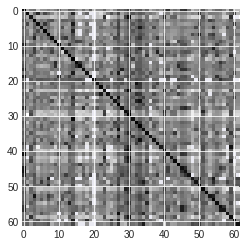

In [19]:
# Making sure our sample for mobility network is reasonable
R = v[0]
plt.imshow(np.log(R[0]))

In [20]:
def get_dist(prior_prams):
    R_dist = []
    T_dist = []
    start_dist = []
    beta_dist = []
    for i in range(len(prior_prams)):
        param_batch = prior_prams[i]
        R_dist.append(param_batch[0])
        T_dist.append(param_batch[1])
        start_dist.append(param_batch[2])
        beta_dist.append(param_batch[3])
    R_dist = tf.concat(R_dist, axis = 0)
    T_dist = tf.concat(T_dist, axis = 0)
    start_dist = tf.concat(start_dist, axis = 0)
    beta_dist = tf.concat(beta_dist, axis = 0)
    # get eta
    E_A = 1/T_dist[:, compartments.index('E'), compartments.index('A')].numpy()
    # get alpha
    A_I = 1/T_dist[:, compartments.index('A'), compartments.index('I')].numpy()
    # get mu
    I_R = 1/T_dist[:, compartments.index('I'), compartments.index('R')].numpy()
    # Getting starting exposed fraction 
    mask = tf.greater(start_dist, 0)
    start_exposed_dist = tf.boolean_mask(start_dist, mask).numpy()
    return [R_dist, E_A, A_I, I_R, start_exposed_dist, beta_dist]
    
def plot_dist(R_dist, E_A, A_I, I_R, start_exposed_dist, beta_dist, name='prior'):
    import seaborn as sns
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,6), dpi=200)
    fig.suptitle(f'Parameter {name} distributions', fontsize=20,y=1.00)
    sns.distplot(x=beta_dist, ax = axs[0,0], axlabel='Beta')
    sns.distplot(x=start_exposed_dist, ax = axs[0,1], axlabel='Exposed start fraction')
    sns.distplot(x=R_dist, ax = axs[0,2], axlabel='Mobility matrix')
    sns.distplot(x=E_A, ax = axs[1,0], axlabel=r'$\eta^{-1}$ : E->A (days)')
    sns.distplot(x=A_I, ax = axs[1,1], axlabel=r'$\alpha ^{-1}$ : A->I (days)')
    sns.distplot(x=I_R, ax = axs[1,2], axlabel=r'$\mu^{-1}$ : I->R (days)')

In [21]:
intial_exposed_guess = 1/np.array(population)
import tqdm
N = 16384
batches = 8
total_batches= N*batches
outs = []
infect = maxentep.contact_infection_func(infections_compartments, area = area)
# model = maxentep.MetaModel(infect, Time,populations = np.round(population))
model = maxentep.MetaModel(infect, Time, populations = population)
prior_prams = []
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
#     R_dist= ps[0]
#     output_list = []
#     for i in range(R_dist.shape[0]):
#         R_dist_d = mobility_matrix
#         norm_R_dist_d = R_dist_d/ tf.math.reduce_sum(R_dist_d, axis = 1, keepdims=True)
#         output_list.append(norm_R_dist_d)
#     outputs = tf.stack(output_list)
#     ps[0] = outputs
    start_dist = ps[2]
    new_start_dist = np.zeros_like(start_dist)
    start_dist_list = []
    for i in range(start_dist.shape[0]):
        index = tf.where(start_dist[i]>0)[0][0].numpy()
        new_start_dist[i,index,0] = intial_exposed_guess[index]
    start_dist_list.append(new_start_dist)
    outputs = tf.stack(start_dist_list, axis =0)
    ps[2] = tf.squeeze(outputs)
    prior_prams.append(ps)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
# trajs = trajs[:,start_time:end_time,:,:]
print(trajs.shape)

100%|██████████| 8/8 [08:55<00:00, 66.99s/it]


(131072, 201, 62, 5)


## Visualizing the unbiased traj

Plotting 62 patches in a 7 x 9 grid


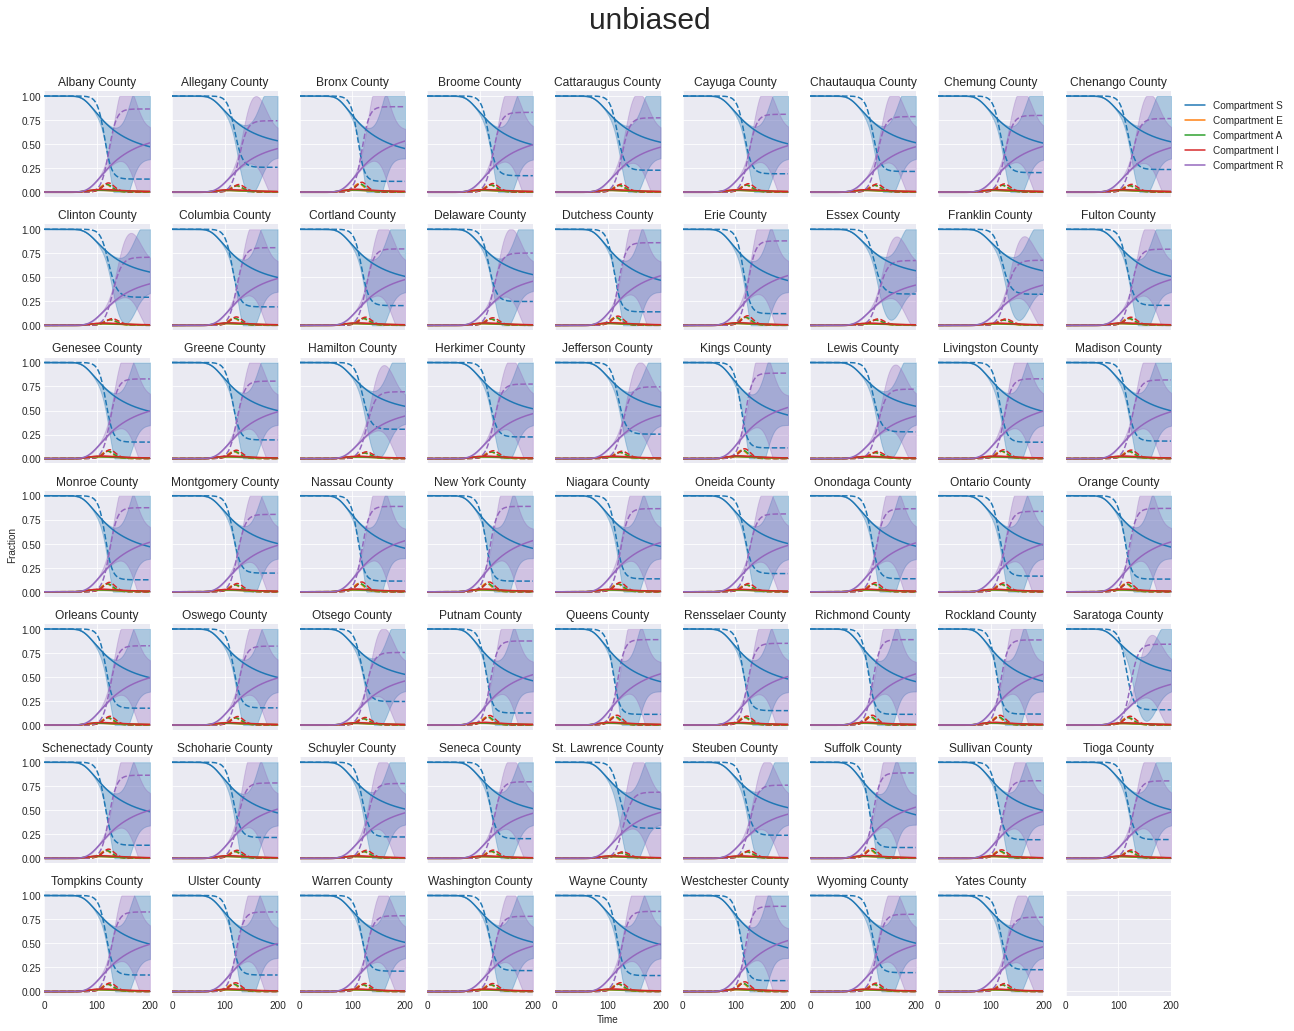

In [22]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
compare_to_ref(ref_traj,trajs, weights=None, method='unbiased', patch_names = patches, 
               figsize=(18, 14), alpha=0.3, names=full_compartments)

<AxesSubplot:ylabel='Count'>

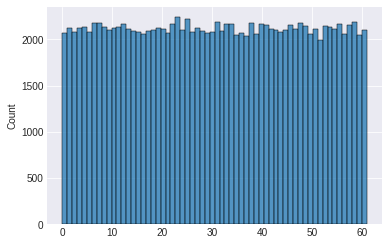

In [23]:
prior_exposed_patch = maxentep.exposed_finder(trajs)
sns.histplot(x=prior_exposed_patch, label='Prior', color='C0',bins=M)

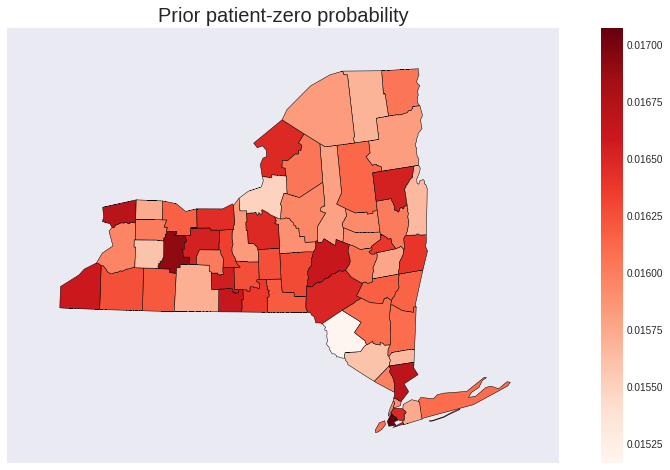

In [24]:
maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability',
                fontsize=20, choropleth=True,
       geojson='counties_ny.geojson')

In [25]:
prior_param_dist = get_dist(prior_prams)

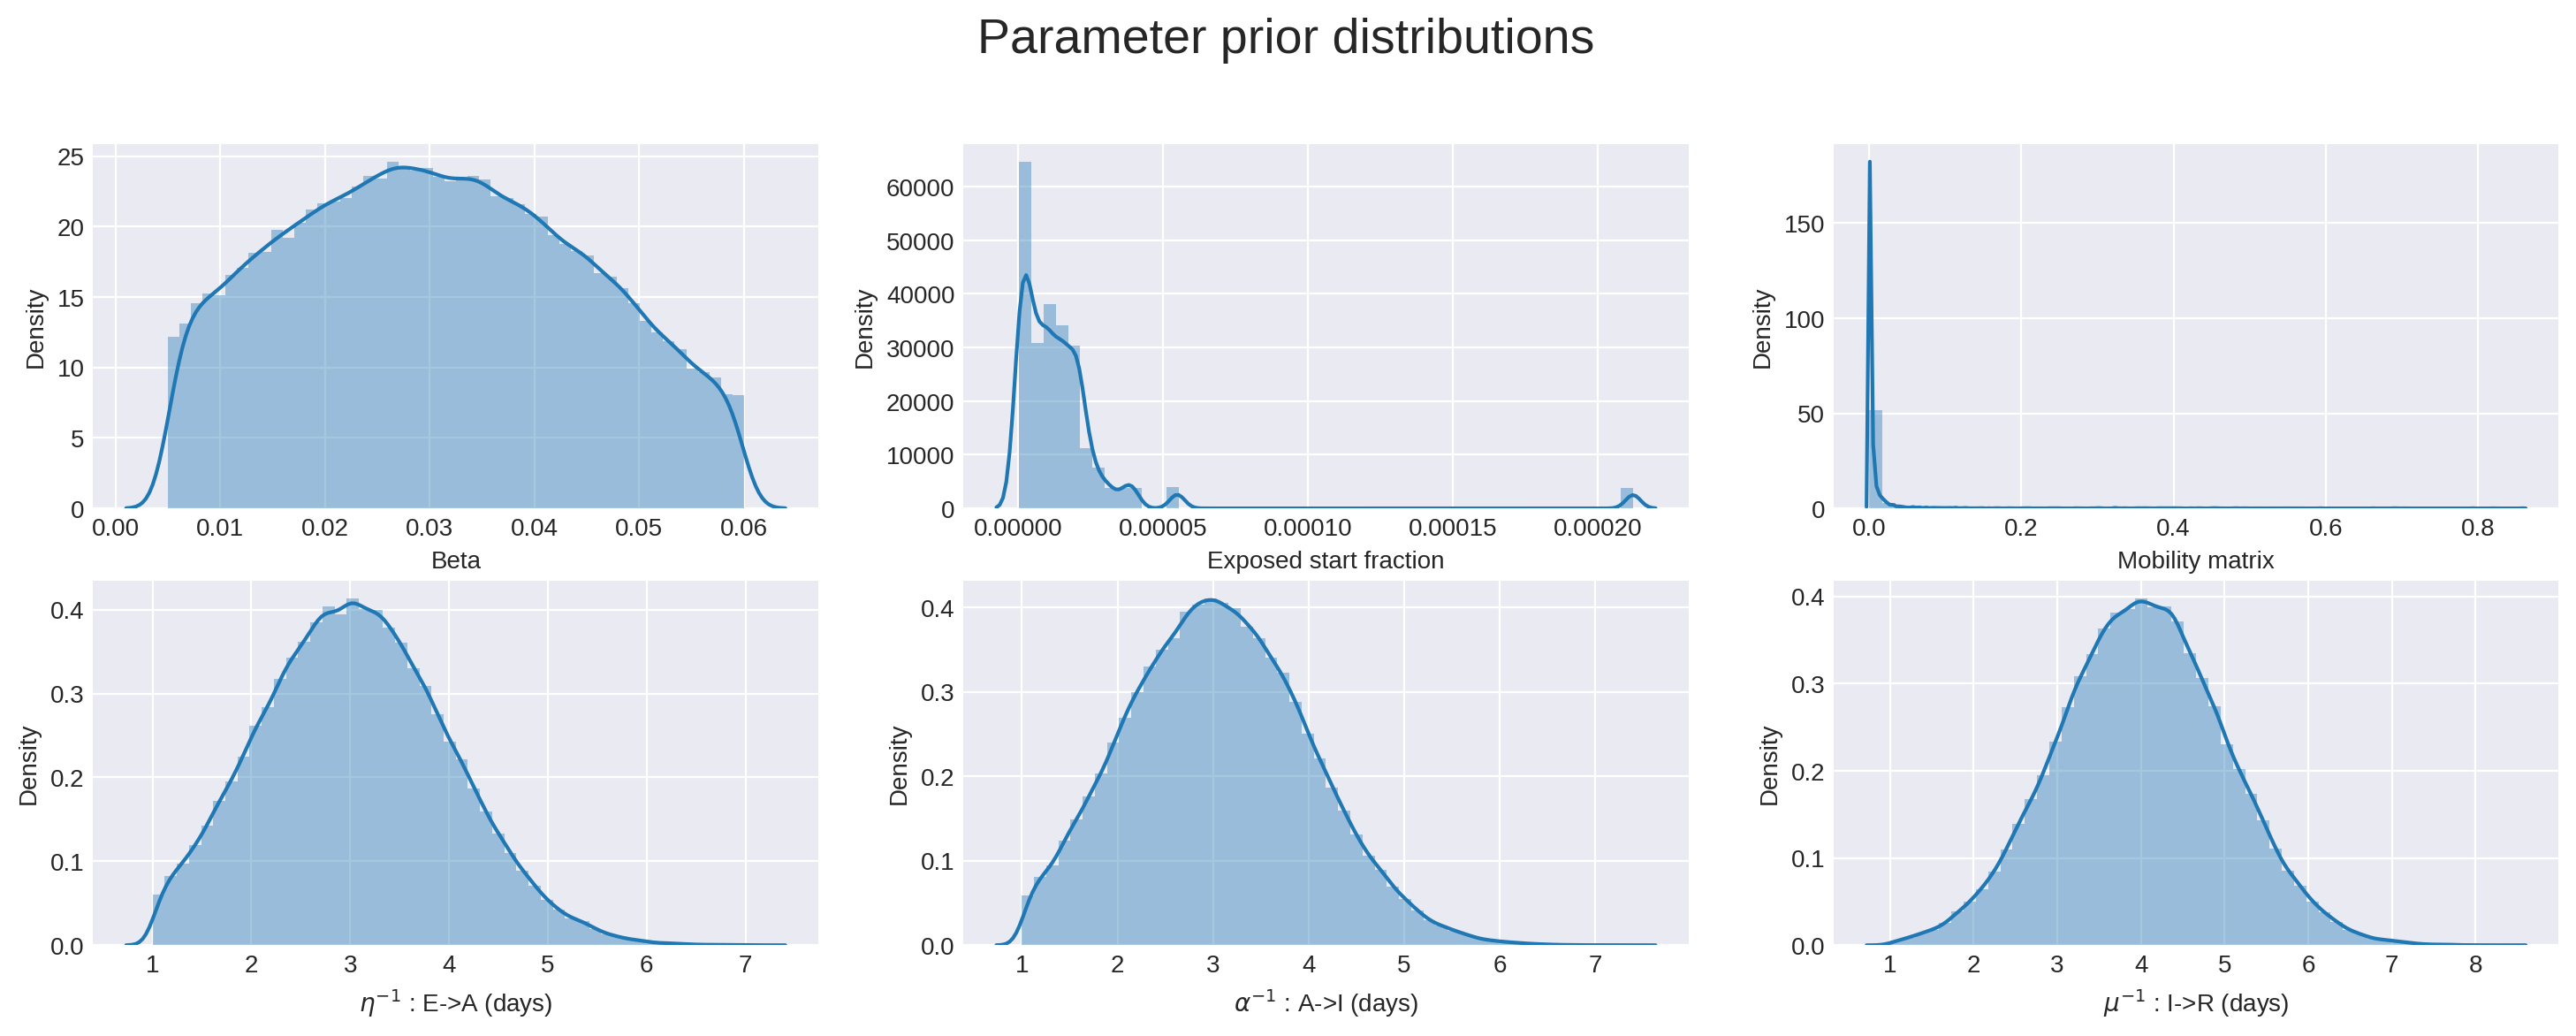

In [26]:
plot_dist(*prior_param_dist)

In [27]:
# ref_traj = tf.squeeze(ref_traj)
# if tf.rank(ref_traj).numpy() != 4:
#     ref_traj = ref_traj[tf.newaxis, ...]
# ref_traj.shape

In [28]:

# print (restrained_compartments_names)
# npoints =4
# prior = maxentep.EmptyPrior()
# cutting the ref_traj in half
# restraints_R, plot_fxn_R = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [restrained_patch,4], npoints, prior, noise=0,time_average=7)
#restraints_E, plot_fxn_E = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,1], npoints, prior, noise=0,time_average=7)
#restraints_A, plot_fxn_A = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,2], npoints, prior, noise=0,time_average=7)
# restraints_I, plot_fxn_I = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [restrained_patch,3], npoints, prior, noise=0,time_average=7)
#restraints_P, plot_fxn_P = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,5], npoints, prior, noise=0,time_average=7)
#restraints_D, plot_fxn_D = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,6], npoints, prior, noise=0,time_average=7)
#restraints = restraints_R + restraints_E + restraints_A + restraints_I + restraints_P + restraints_D
#plot_fxns = plot_fxn_R + plot_fxn_E + plot_fxn_A + plot_fxn_I + plot_fxn_P + plot_fxn_D
# restraints = restraints_I + restraints_R
# plot_fxns = plot_fxn_I + plot_fxn_R


In [29]:
me_model = maxentep.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')

In [30]:
# class CustomCallback(tf.keras.callbacks.Callback):
#     def __init__(self):
#         self. i = 0
#     def on_epoch_begin(self, epoch, logs=None):
#         self.i += 1
#         return self.i


In [31]:
me_history = me_model.fit(trajs, batch_size=N//2,epochs=1000)#, callbacks=[CustomCallback()])

Epoch 1/1000
16/16 [==============================] - 0s 2ms/step - loss: 0.0066 - weight-entropy: 8.7267
Epoch 2/1000
16/16 [==============================] - 0s 2ms/step - loss: 9.8552e-04 - weight-entropy: 8.2488
Epoch 3/1000
16/16 [==============================] - 0s 2ms/step - loss: 5.0530e-04 - weight-entropy: 8.0178
Epoch 4/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.9145e-04 - weight-entropy: 7.9329
Epoch 5/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.4163e-04 - weight-entropy: 7.8582
Epoch 6/1000
16/16 [==============================] - 0s 2ms/step - loss: 3.1529e-04 - weight-entropy: 7.8083
Epoch 7/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.9901e-04 - weight-entropy: 7.7654
Epoch 8/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.8869e-04 - weight-entropy: 7.7292
Epoch 9/1000
16/16 [==============================] - 0s 2ms/step - loss: 2.7990e-04 - weight-entropy: 7.7013
Epoch 10/1000


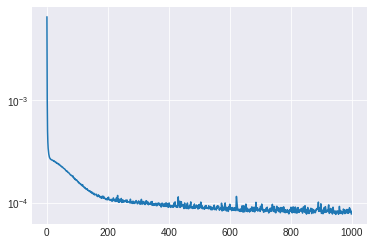

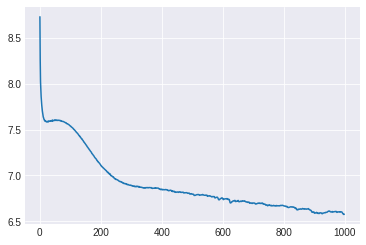

In [32]:
plt.plot(me_history.history['loss'])
plt.yscale('log')
plt.show()
plt.plot(me_history.history['weight-entropy'])
plt.show()

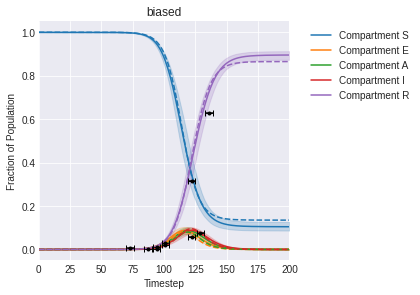

In [33]:
patch_number = 0
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights,alpha=0.2, names=full_compartments)
plt.plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(plt, me_model.lambdas[i], color='k')
plt.tight_layout()
# plt.ylim(0,0.2)
# plt.xlim(0,75)
plt.title('biased')
plt.show()

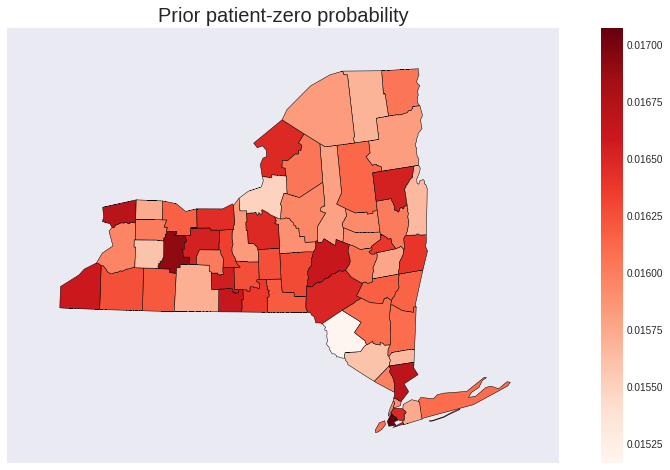

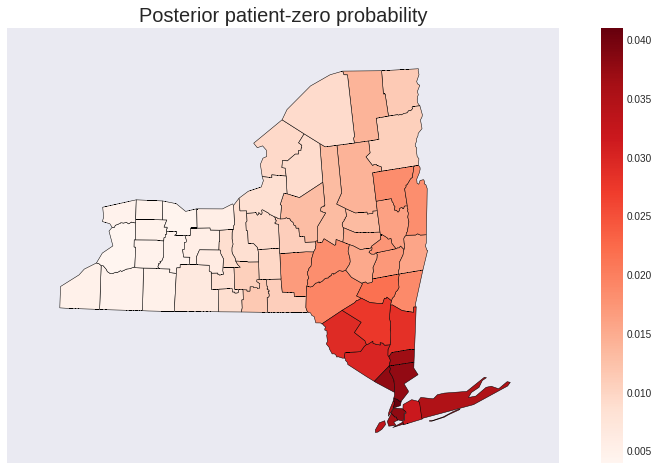

In [34]:
me_w = me_model.traj_weights
prior_exposed_patch = maxentep.exposed_finder(trajs)
posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)
maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability', fontsize=20, choropleth=True,
       geojson='counties_ny.geojson')
maxentep.p0_map(prior_exposed_patch, M, weights = me_w, title = 'Posterior patient-zero probability', patch_names=patches, fontsize=20
      , choropleth=True, geojson='counties_ny.geojson')

In [35]:
sorted(zip(prior_exposed_patch, patches), reverse=True)[:5]

[(61, 'Westchester County'),
 (60, 'Hamilton County'),
 (58, 'Monroe County'),
 (54, 'Sullivan County'),
 (52, 'Jefferson County')]

In [36]:
sorted(zip(posterior_exposed_prob, patches), reverse=True)[:5]

[(0.04102200204916295, 'Bronx County'),
 (0.037970495264870244, 'Rockland County'),
 (0.037884444824697064, 'Queens County'),
 (0.03774769320738388, 'Westchester County'),
 (0.036705286691135604, 'Putnam County')]

## Algorithm 2

In [37]:
fit_param_model = maxentep.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model',hypers = hyper_pram )
fit_param_model.compile(tf.optimizers.SGD(1))

hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model, reweight=False)
hme_model.compile(tf.keras.optimizers.SGD(learning_rate=1), 'mean_squared_error')

In [38]:
hme_history = hme_model.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=3, param_epochs=50, batch_size=N, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0291 - weight-entropy: 9.7041
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0257 - weight-entropy: 9.7004
Epoch 3/100
1/1 [==============================] - 0s 968us/step - loss: 0.0240 - weight-entropy: 9.6937
Epoch 4/100
1/1 [==============================] - 0s 776us/step - loss: 0.0230 - weight-entropy: 9.6868
Epoch 5/100
1/1 [==============================] - 0s 608us/step - loss: 0.0224 - weight-entropy: 9.6807
Epoch 6/100
1/1 [==============================] - 0s 597us/step - loss: 0.0221 - weight-entropy: 9.6754
Epoch 7/100
1/1 [==============================] - 0s 649us/step - loss: 0.0218 - weight-entropy: 9.6710
Epoch 8/100
1/1 [==============================] - 0s 936us/step - loss: 0.0216 - weight-entropy: 9.6673
Epoch 9/100
1/1 [==============================] - 0s 908us/step - loss: 0.0215 - weight-entropy: 9.6643
Epoch 10/100
1/1 [==============================] - 0s 730u

In [39]:
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error') 
# hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), loss=ref_traj_loss)
hme_final_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=N, epochs=500)

Epoch 1/500
8/8 [==============================] - 0s 4ms/step - loss: 0.0221 - weight-entropy: 9.6925
Epoch 2/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0205 - weight-entropy: 9.6827
Epoch 3/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0189 - weight-entropy: 9.6804
Epoch 4/500
8/8 [==============================] - 0s 4ms/step - loss: 0.0172 - weight-entropy: 9.6583
Epoch 5/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0155 - weight-entropy: 9.6247
Epoch 6/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0139 - weight-entropy: 9.5825
Epoch 7/500
8/8 [==============================] - 0s 4ms/step - loss: 0.0124 - weight-entropy: 9.5307
Epoch 8/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0111 - weight-entropy: 9.4726
Epoch 9/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0099 - weight-entropy: 9.4111
Epoch 10/500
8/8 [==============================] - 0s 3ms/step - loss: 0

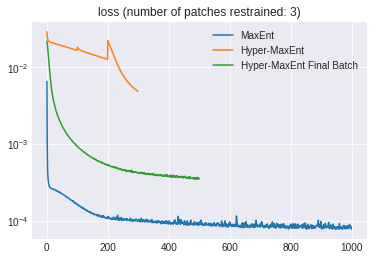

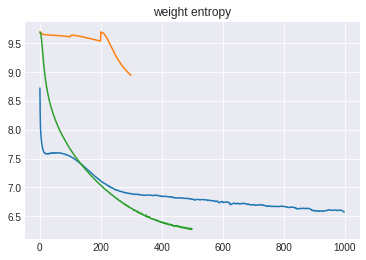

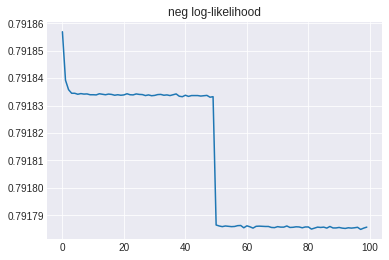

In [40]:
plt.plot(me_history.history['loss'],label='MaxEnt')
plt.plot(hme_history.history['loss'],label='Hyper-MaxEnt')
plt.plot(hme_final_history.history['loss'],label='Hyper-MaxEnt Final Batch')
plt.title('loss (number of patches restrained: {})'.format(len(restrained_patches)))
plt.yscale('log')
plt.legend()
plt.savefig('loss_{}_restraints'.format(len(restrained_patches)),dpi= 300)
plt.show()

plt.plot(me_history.history['weight-entropy'])
plt.plot(hme_history.history['weight-entropy'])
plt.plot(hme_final_history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(hme_history.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

# plt.plot(hme_history.history['loss-from-ref'])
# plt.show()

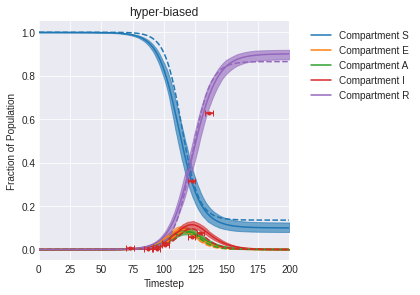

In [41]:
patch_number = 0
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments)
plt.plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(plt, hme_model.lambdas[i], color='C3')
plt.tight_layout()
# plt.ylim(0,0.2)
# plt.xlim(0,75)
plt.title('hyper-biased')
plt.show()


## Direct Regression of Model

In [42]:
T = tmat.value
start = np.zeros((M, C))
start[0,1] = 1e-6
infect = maxentep.ContactInfectionLayer(hyper_pram.beta_start, infections_compartments, area=area)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, mobility_matrix, T, infect, Time, agreement, populations=population)

In [43]:
rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(150)
rtraj = rmodel.get_traj()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

150/150 [==============================] - 16s 110ms/step - loss: 5.8551 - output_2_loss: 5.8551


## Visualizing results

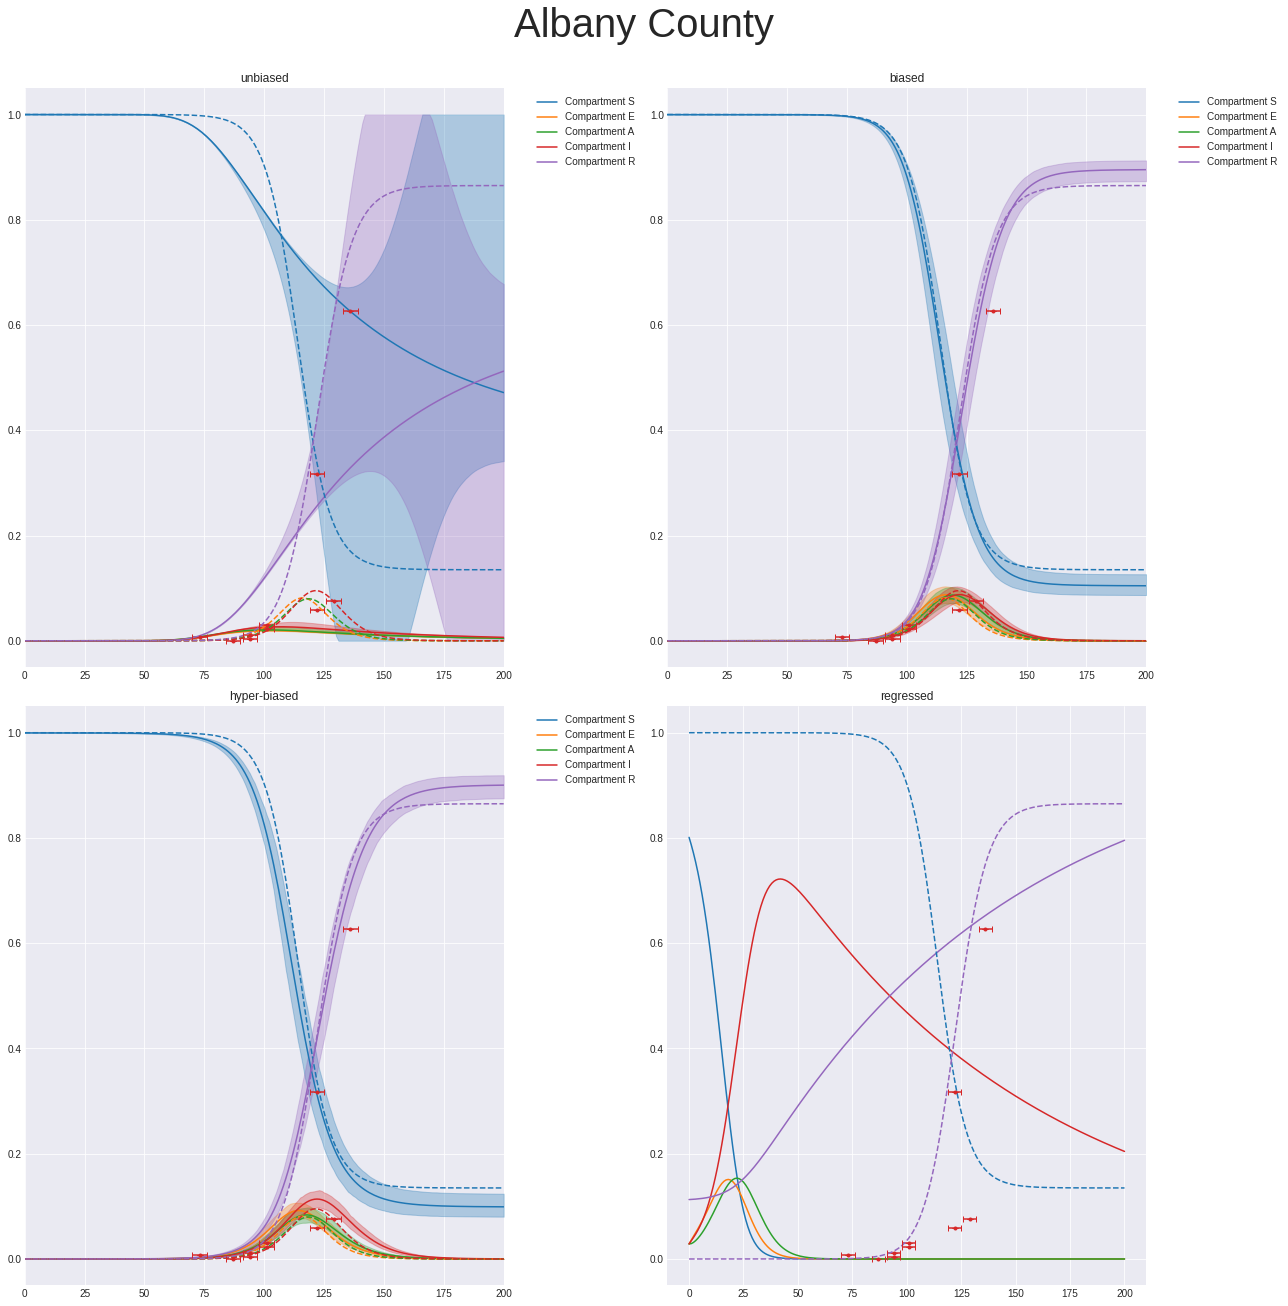

In [44]:
patch_number = 0
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0],alpha = 0.3)
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')

for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[0,0], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments,alpha = 0.3, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], alpha = 0.3,weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,1], 1, color='C3')

    
plt.tight_layout()
# plt.savefig('compare_Albany.png', dpi = 300)
plt.show()
plt.close()

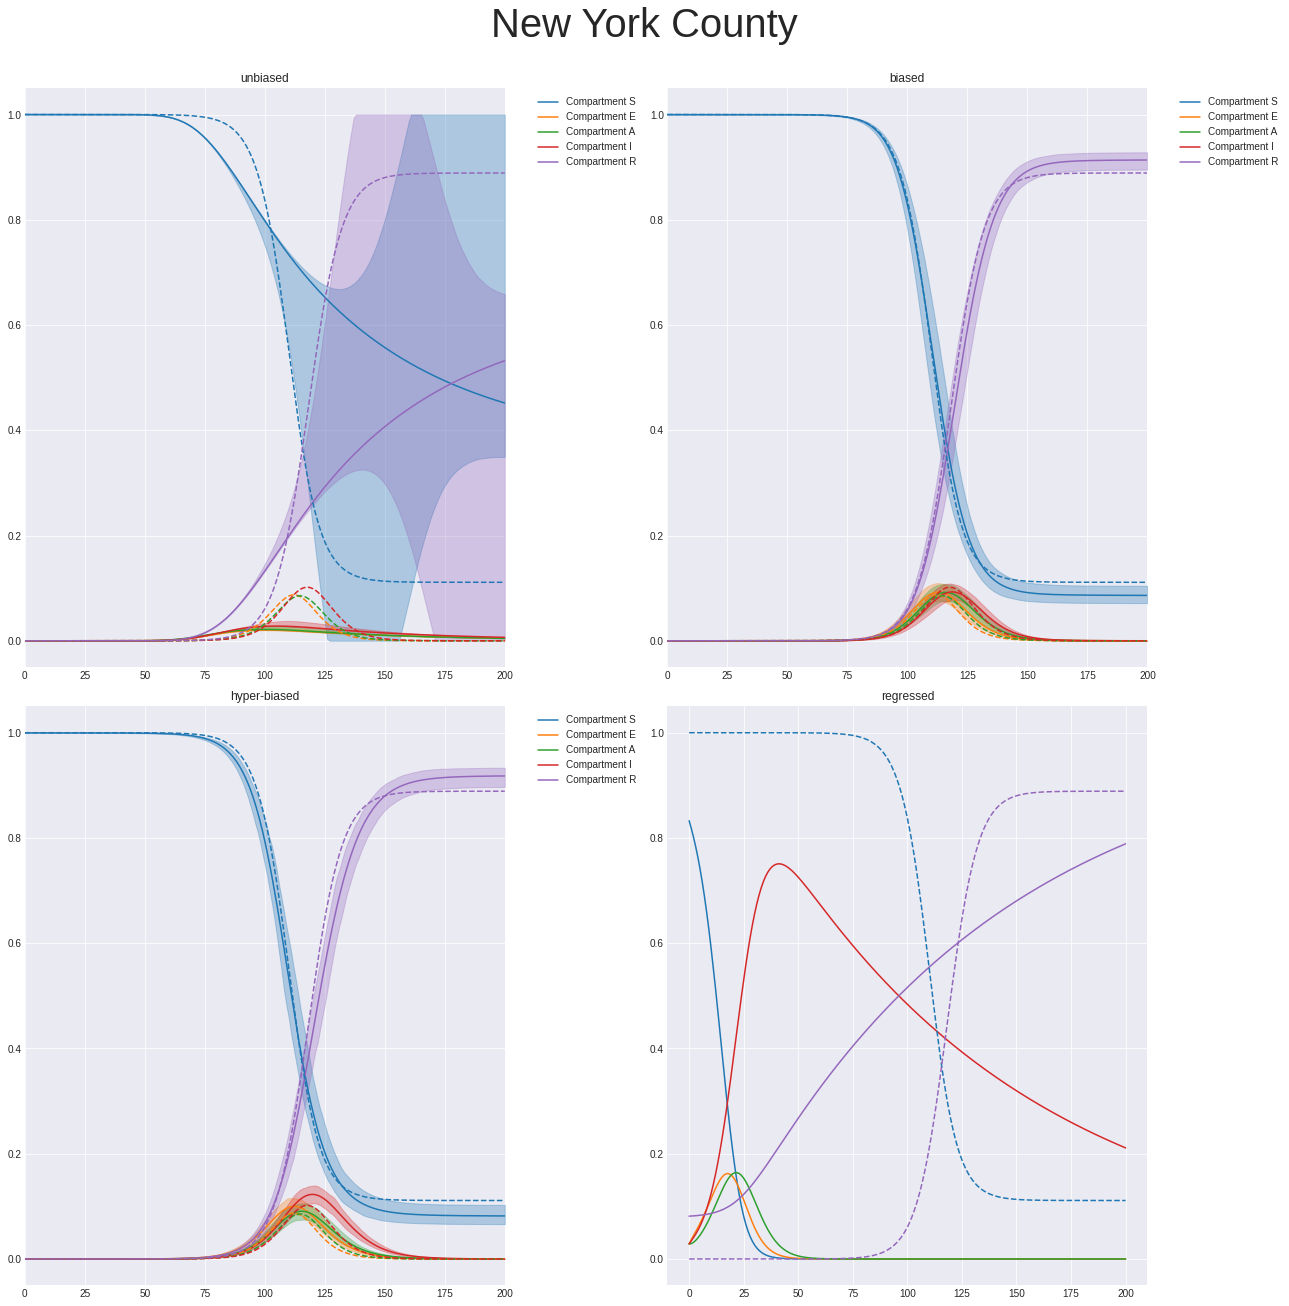

In [45]:
patch_number = 30
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0],alpha = 0.3)
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# ax[0,0].tick_params(color='green', labelcolor='green')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[0,0], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, alpha = 0.3,names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[0,1], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, alpha = 0.3,names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[1,0], hme_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[1,1], 1, color='C3')

plt.tight_layout()
# plt.savefig('compare_NY.png', dpi = 300)
plt.show()
plt.close()

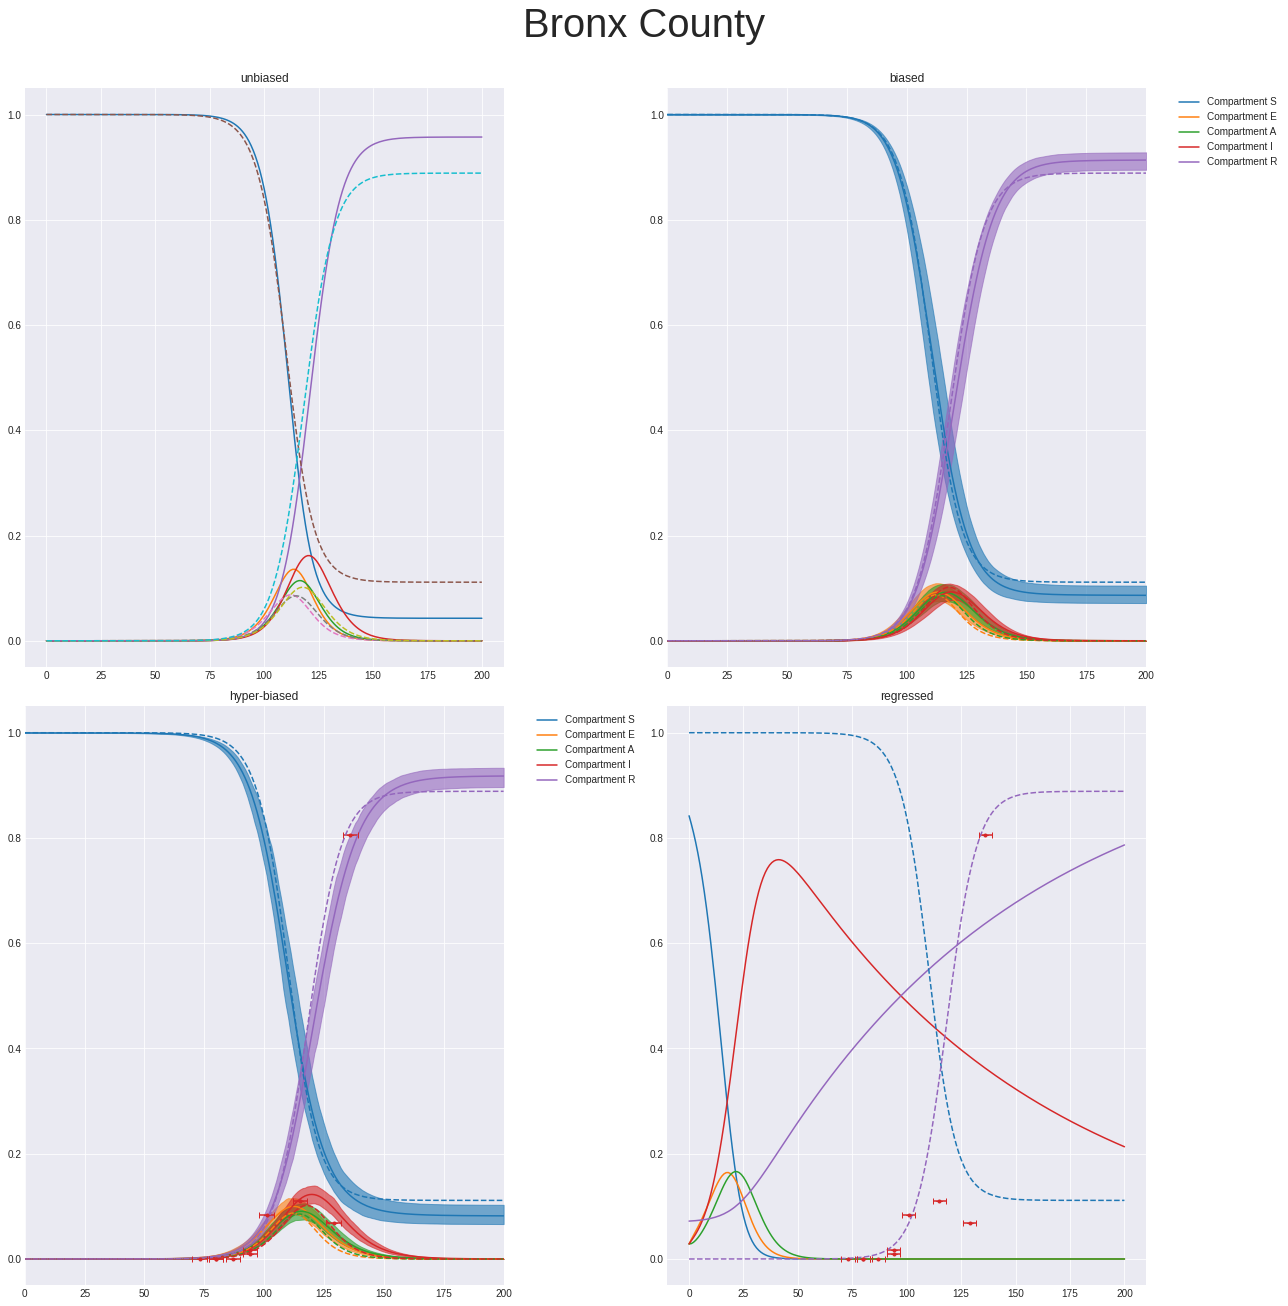

(1, 201, 62, 5)


In [46]:
patch_number = 2
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
axs[0,0].plot(trajs[0,:,patch_number,:])
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns_list[patch_number]):
#     pf(axs[0,0], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns_list[patch_number]):
#     pf(axs[0,1], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,1], 1, color='C3')

plt.tight_layout()
plt.savefig('compare_Livingston.png', dpi = 300)
plt.show()
print (ref_traj.shape)

In [47]:
weights_dict = {'unbiased':None, 'biased':me_model.traj_weights, 'hyper-biased':hme_model.traj_weights, 'regression':None }
from matplotlib.patches import Patch
print (restrained_patches)
def compare_patches(ref_traj,trajs,weights_dict, method ,*args, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
    weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.03)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.03)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[p,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
            if i * ncol + j in restrained_patches and method != 'unbiased':
                for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
                    pf(ax[i,j],0, color='C3')
                ax[i,j].spines['bottom'].set_color('y')
                ax[i,j].spines['top'].set_color('y') 
                ax[i,j].spines['right'].set_color('y')
                ax[i,j].spines['left'].set_color('y')
                ax[i,j].spines['left'].set_linewidth(2)
                ax[i,j].spines['top'].set_linewidth(2)
                ax[i,j].spines['right'].set_linewidth(2)
                ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
    plt.tight_layout()


[17 26 51]


Plotting 62 patches in a 7 x 9 grid


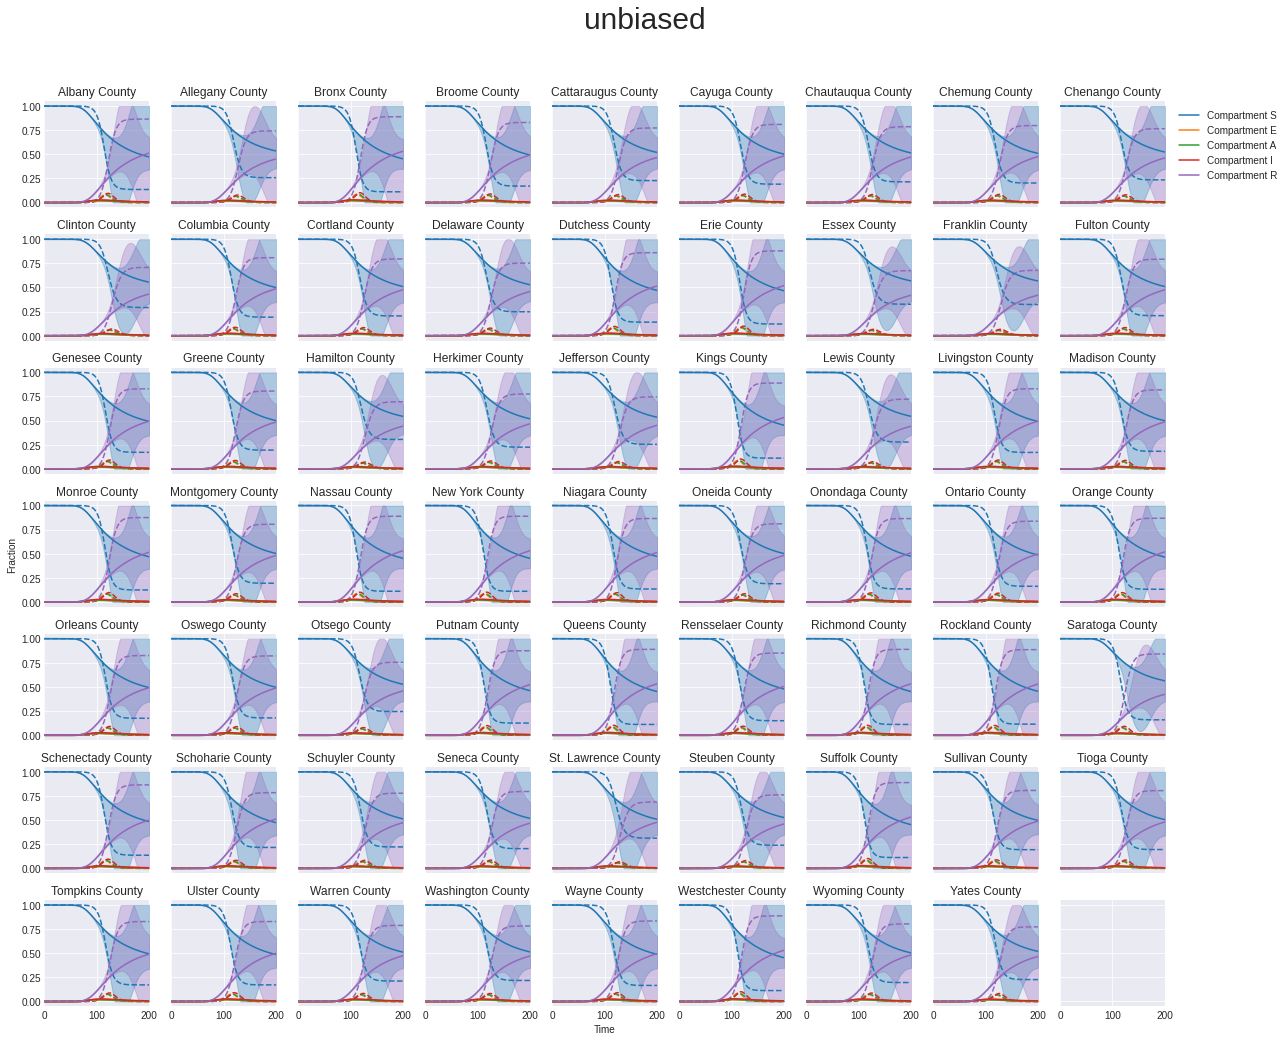

In [48]:
compare_patches(ref_traj,trajs,weights_dict,'unbiased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_unbiased.png',dpi=300)
# (ref_traj, trajs,weights_dict,'biased',patch_names = patches)

Plotting 62 patches in a 7 x 9 grid


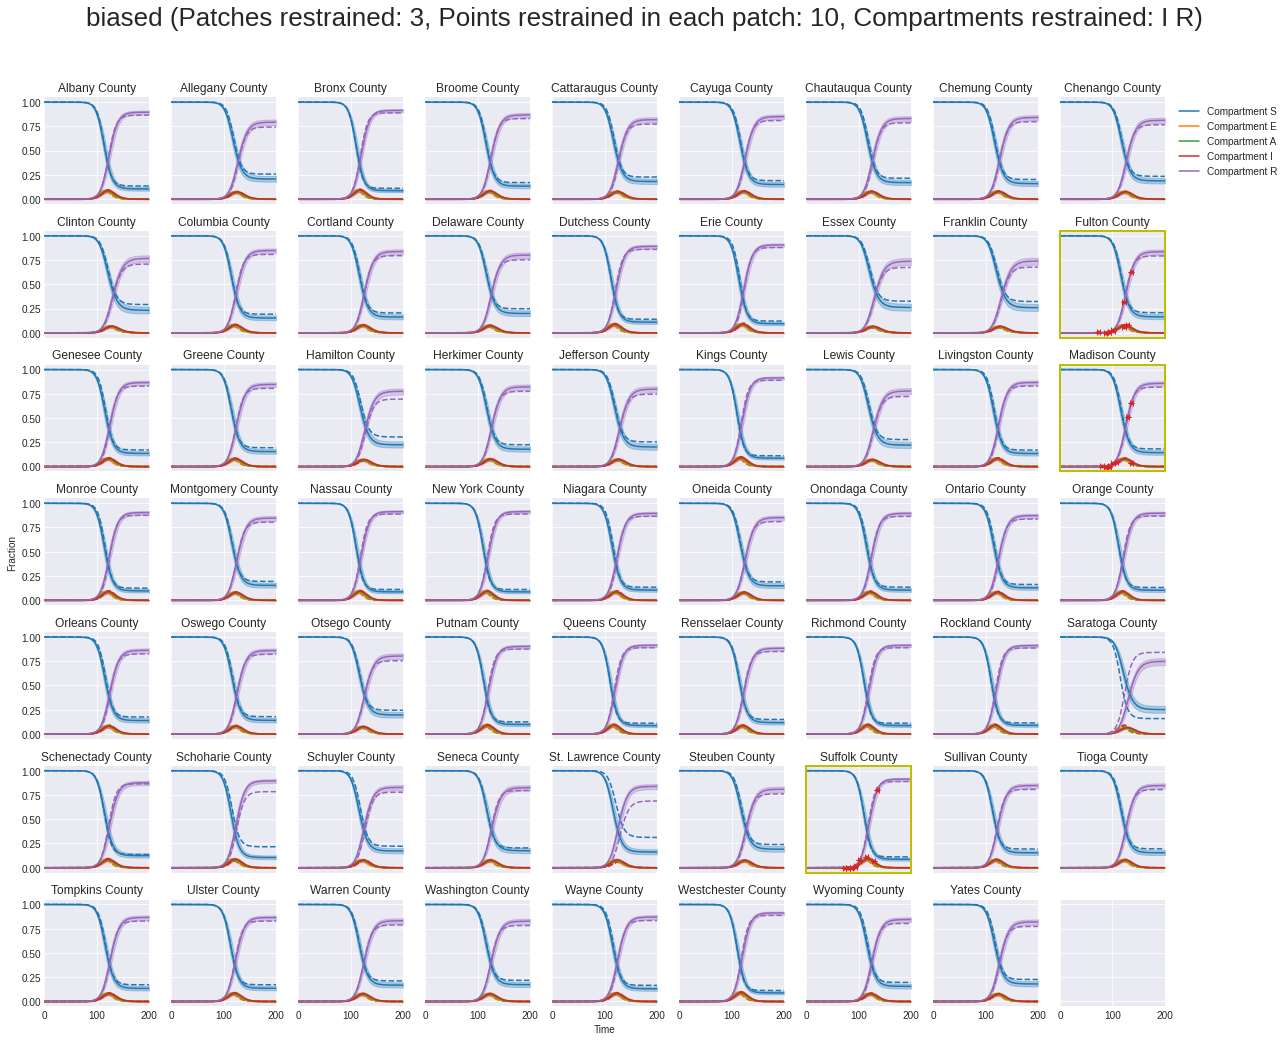

In [49]:
compare_patches(ref_traj,trajs,weights_dict,'biased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_biased_{}_restrained_{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)
# (ref_traj, trajs,weights_dict,'biased',patch_names = patches)

Plotting 62 patches in a 7 x 9 grid


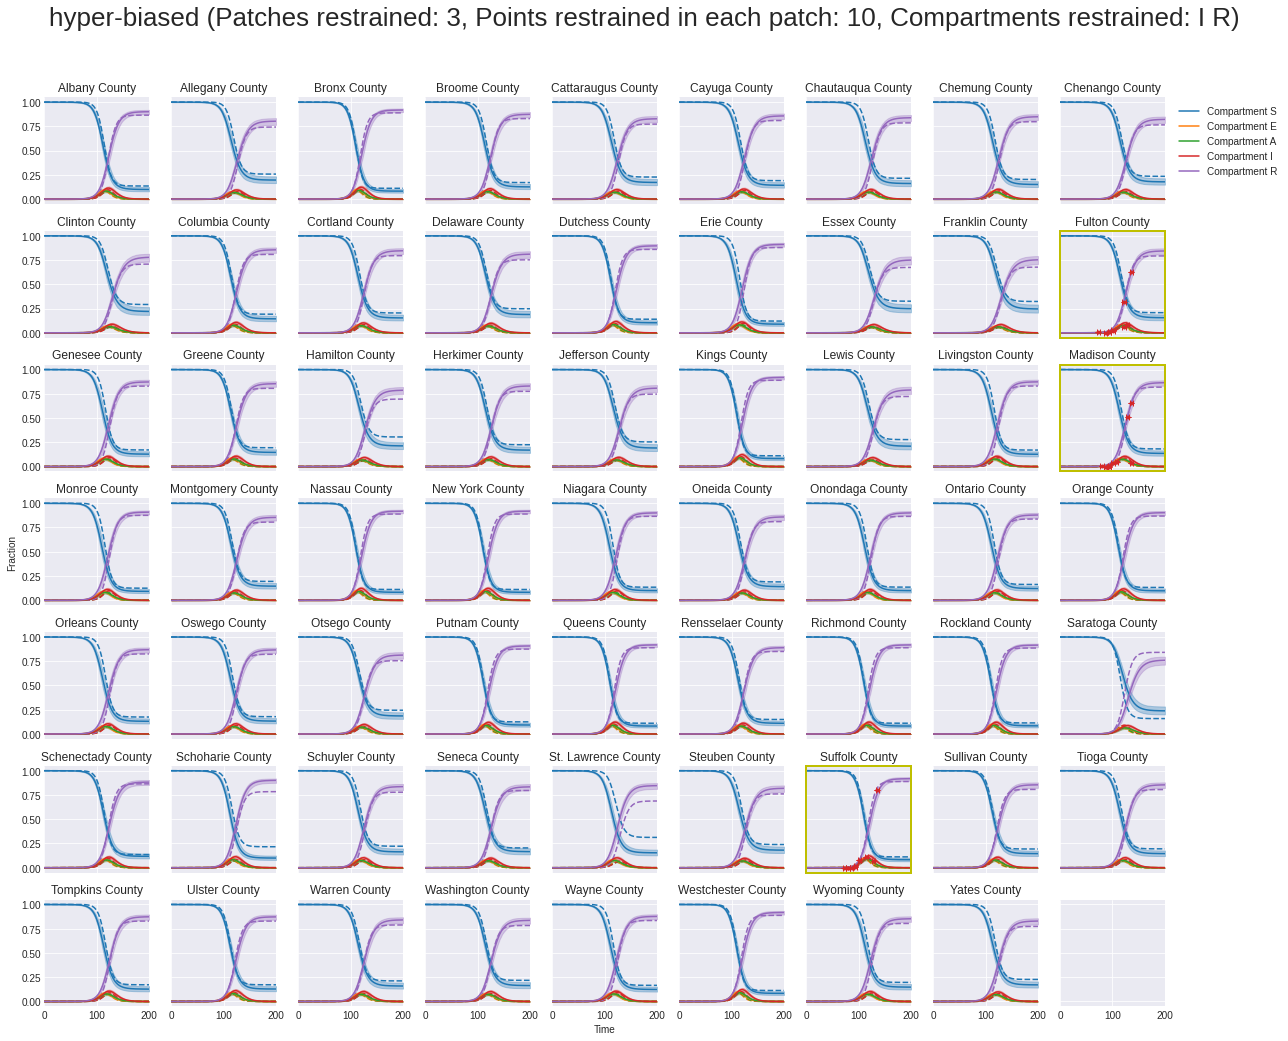

In [50]:
compare_patches(ref_traj,hme_model.trajs,weights_dict,'hyper-biased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_hyper_{}_restrained_{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)

In [51]:
weight_hyper = weights_dict['hyper-biased']
# weight_hyper /=np.sum(weight_hyper)
# mtrajs_patch = np.sum(trajs[:,:,0,:] * weight_hyper[:, np.newaxis, np.newaxis], axis=0)
# print (trajs.shape)
# print (mtrajs_patch.shape)
# print (trajs.shape[2], trajs.shape[-1])
def mean_traj(trajs,weights=None):
    Time = trajs.shape[1]
    c = trajs.shape[-1]
    M = trajs.shape[2]
    if weights is None:
        w = np.ones(trajs.shape[0])
    else:
        w = weights
    w /= np.sum(w)
    mtrajs_counties = np.empty([Time,M,c])
    for i in range(M):
        mtrajs_counties[:,i,:] = np.sum(trajs[:,:,i,:] * w[:, np.newaxis, np.newaxis], axis=0)
    mtrajs = np.sum(mtrajs_counties*population_fraction[np.newaxis, :, np.newaxis],axis=1)
    return mtrajs

    
mtrajs_hyper_biased = mean_traj(hme_model.trajs,weights = weights_dict['hyper-biased'])



mtrajs_biased = mean_traj(trajs,weights = weights_dict['biased'])
mtrajs_unbiased = mean_traj(trajs)
# REF = ref_traj[p,:,:,:]
# REF = np.expand_dims(REF,axis=0)
mref_traj = mean_traj(ref_traj)


mref_traj = mref_traj[:,:5]

loss_unbiased = np.mean((mref_traj- mtrajs_unbiased)**2)
loss_biased = np.mean((mref_traj- mtrajs_biased)**2)
loss_hyper_biased = np.mean((mref_traj- mtrajs_hyper_biased)**2)



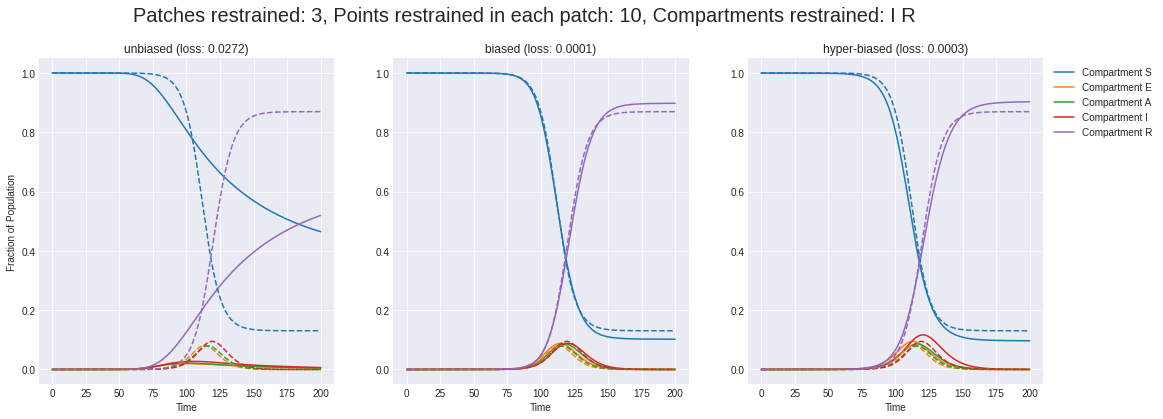

0.9999348556436718


In [52]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
fig.suptitle('Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {}'
             .format(len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names), fontsize=20,y=1.00)

axs[0].set_title('unbiased (loss: {})'.format(np.round(loss_unbiased,4)))
axs[1].set_title('biased (loss: {})'.format(np.round(loss_biased,4)))
axs[2].set_title('hyper-biased (loss: {})'.format(np.round(loss_hyper_biased,4)))
for i in range(mref_traj.shape[-1]):
    axs[0].plot(range(Time),mtrajs_unbiased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')
    axs[1].plot(range(Time),mtrajs_biased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')
    axs[2].plot(range(Time),mtrajs_hyper_biased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')

axs[0].plot(mref_traj,linestyle='--')
axs[1].plot(mref_traj,linestyle='--')
axs[2].plot(mref_traj,linestyle='--')
axs[2].legend(bbox_to_anchor=(1.4, 1))
plt.setp(axs[:], xlabel='Time')
plt.setp(axs[0], ylabel='Fraction of Population')

# plt.tight_layout()
plt.savefig('compare_means_restraints_{}{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)
plt.show()
print (np.sum(mtrajs_biased[-1]))

In [53]:
Loss = np.mean((mref_traj- mtrajs_unbiased)**2)
print (Loss)

# print(end - start)

0.02720914101178631


Plotting 62 patches in a 7 x 9 grid


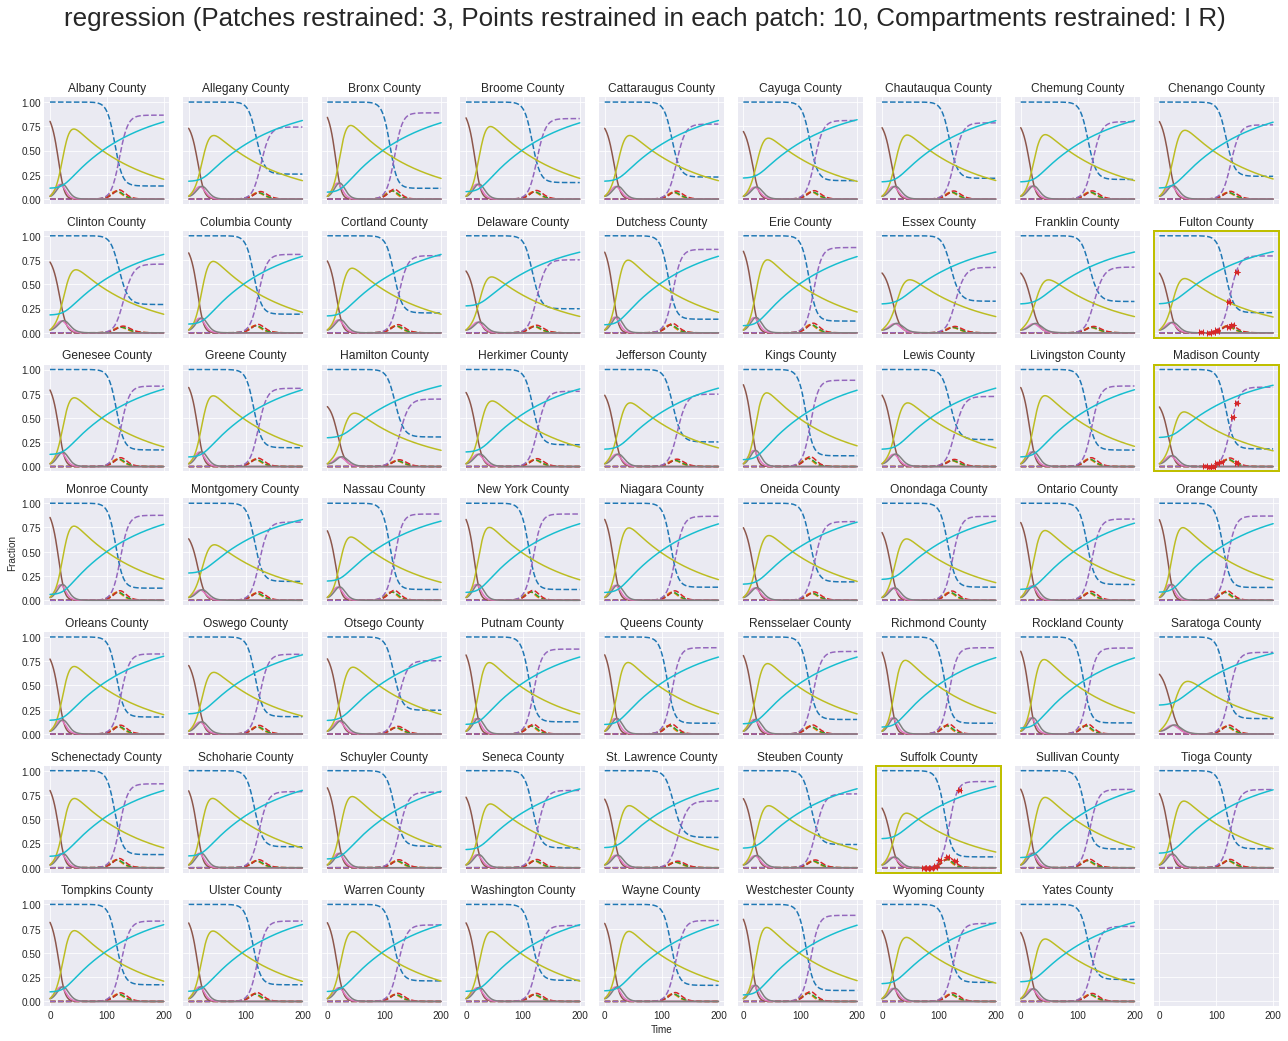

In [54]:
compare_patches(ref_traj,trajs,weights_dict,'regression', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_regression.png',dpi=300)


# Parameter posterior distributions

No handles with labels found to put in legend.


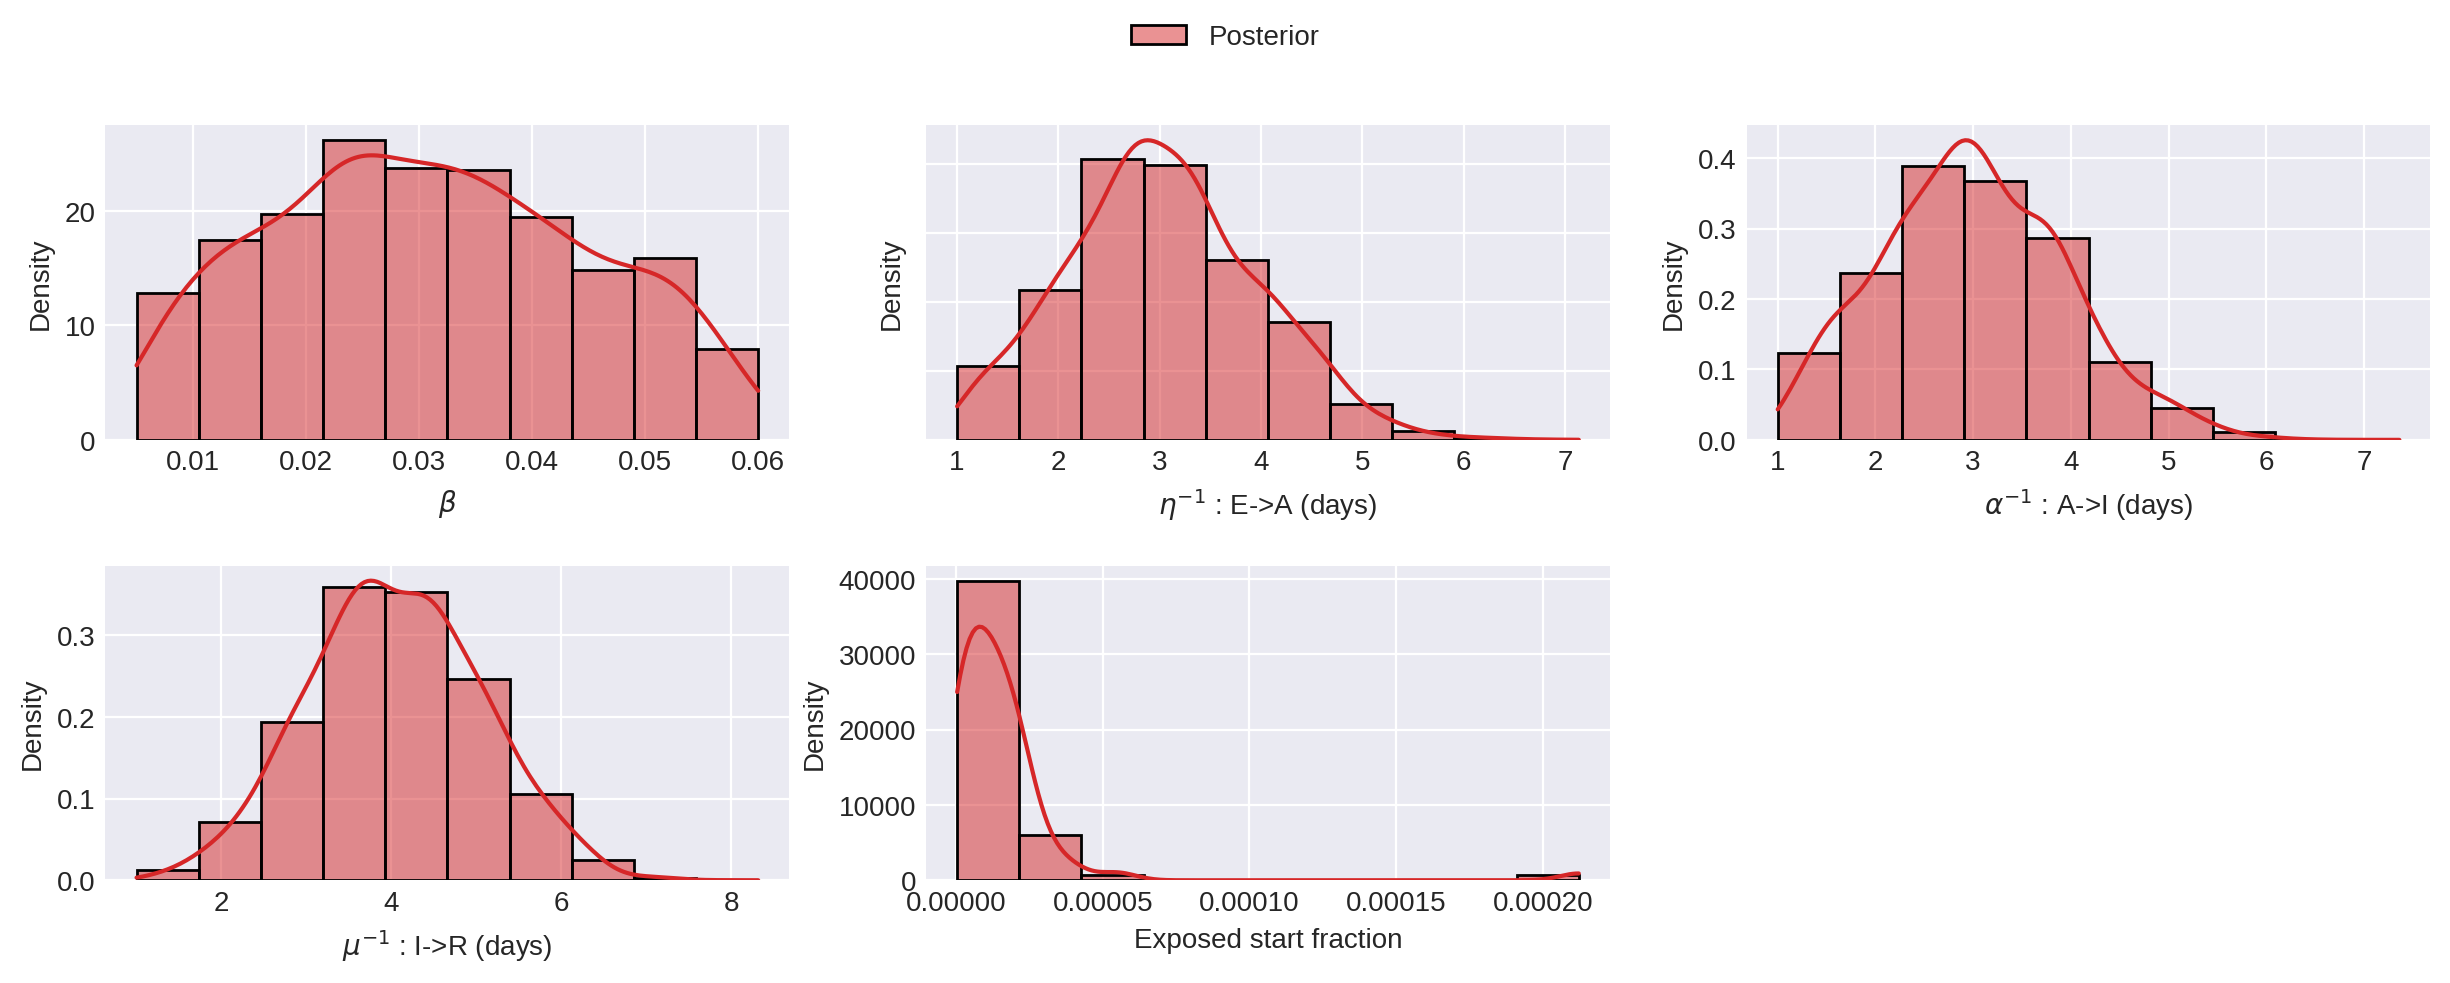

In [55]:

R_dist, E_A, A_I, I_R, start_exposed_dist, beta_dist = prior_param_dist
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,5), dpi=200)
sns.histplot(x=np.squeeze(beta_dist), weights=hme_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,0], kde=True, stat="density")
axs[0,0].set_xlabel(r'$\beta$')

sns.histplot(x=np.squeeze(E_A), weights=hme_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,1], kde=True, stat="density")
axs[0,1].set_xlabel(r'$\eta^{-1}$ : E->A (days)')

sns.histplot(x=np.squeeze(A_I), weights=hme_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,2], kde=True, stat="density")
axs[0,2].set_xlabel(r'$\alpha ^{-1}$ : A->I (days)')

sns.histplot(x=np.squeeze(I_R), weights=hme_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,0], kde=True, stat="density")
axs[1,0].set_xlabel(r'$\mu^{-1}$ : I->R (days)')

sns.histplot(x=np.squeeze(start_exposed_dist), weights=hme_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,1], kde=True, stat="density")
axs[1,1].set_xlabel('Exposed start fraction')


handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.subplots_adjust(hspace=0.4)
axs[-1, -1].axis('off')
axs[0,1].set_yticklabels('')
plt.legend()
# sns.displot(x=np.squeeze(beta_dist),stat="density", kde=True)

# Compare posterior with prior

No handles with labels found to put in legend.


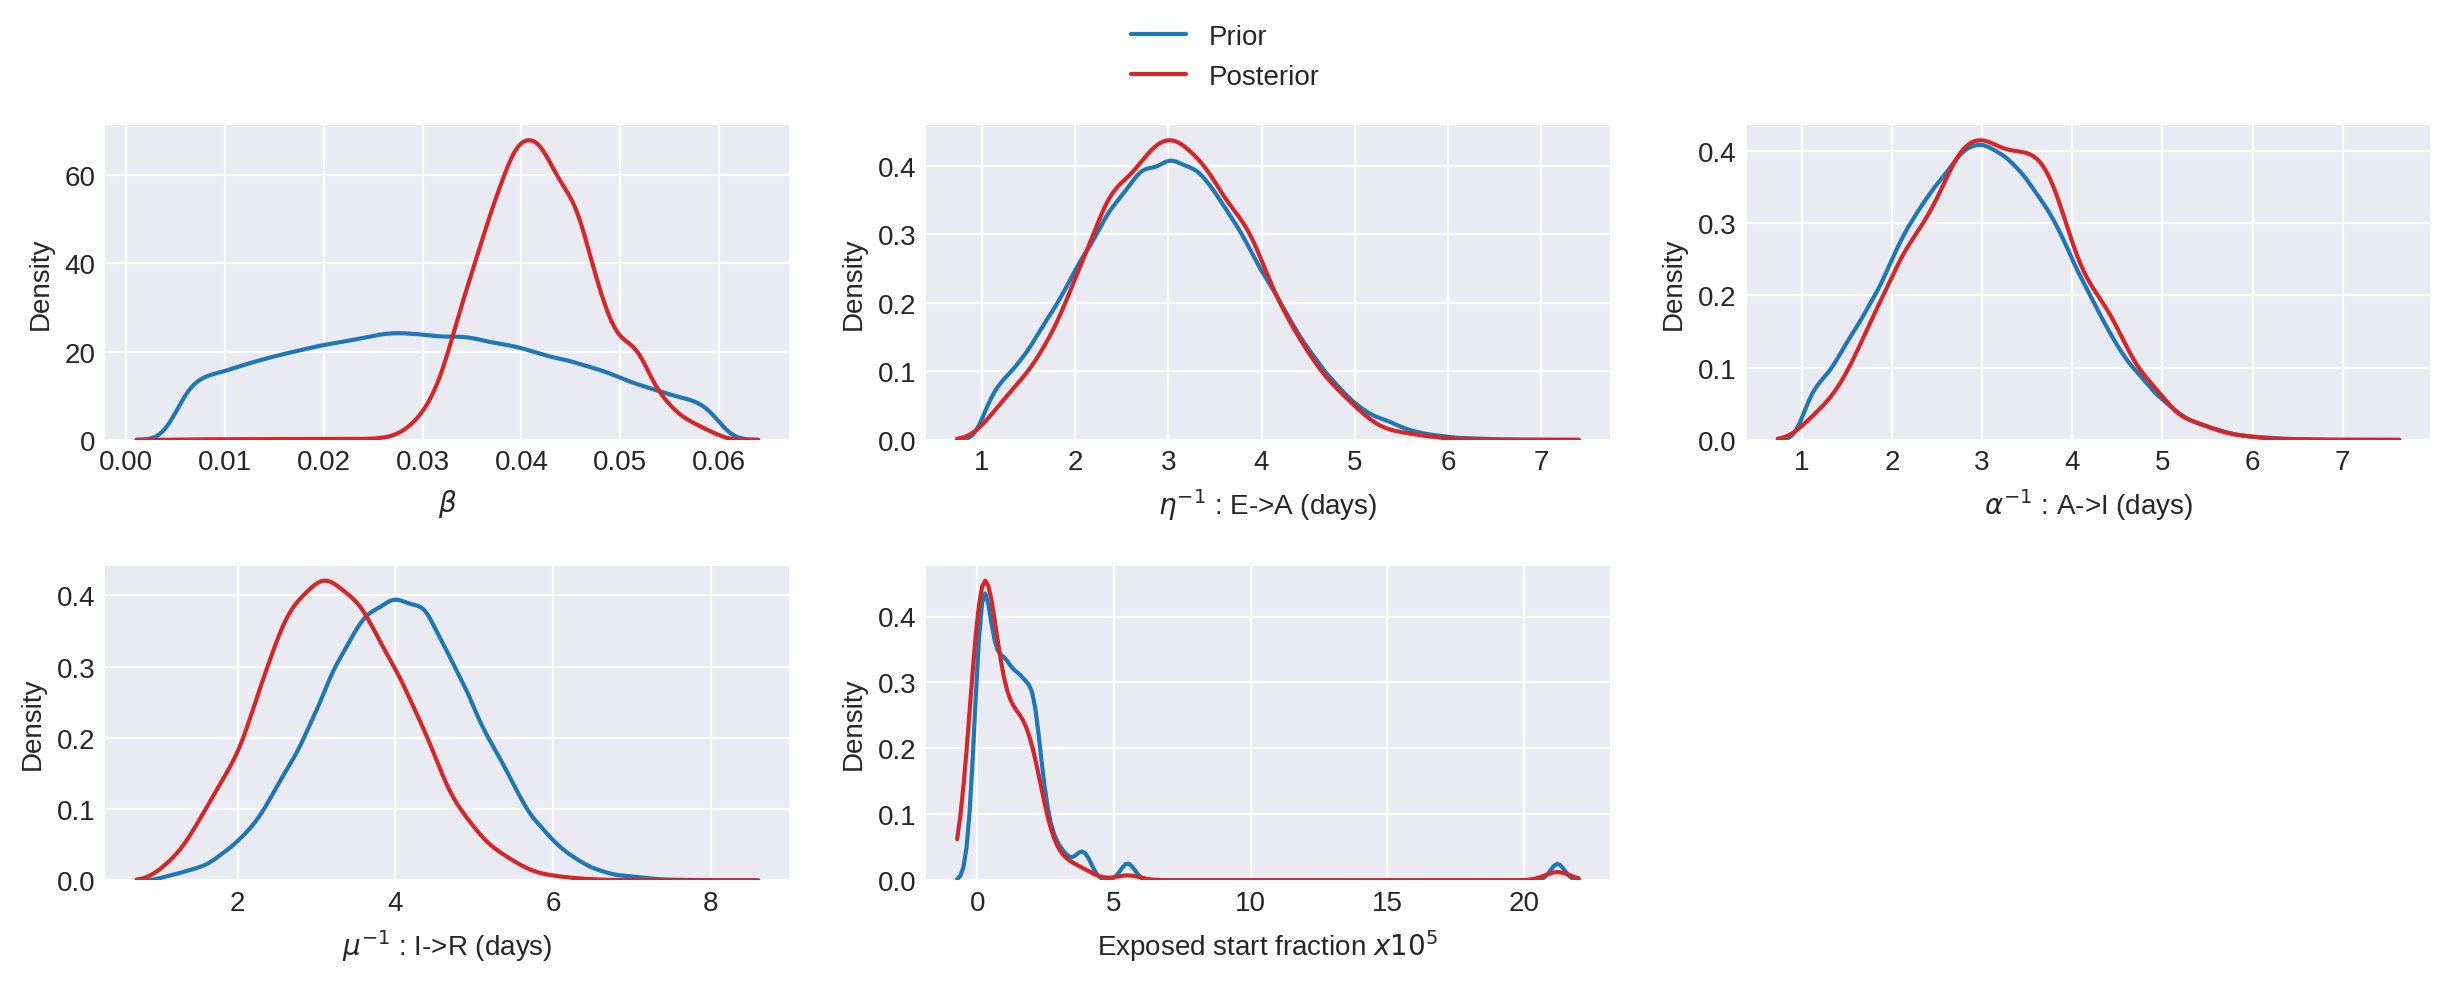

In [56]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,5), dpi=200)
sns.kdeplot(x=np.squeeze(beta_dist), label='Prior',
            color='C0', ax=axs[0,0])
sns.kdeplot(x=np.squeeze(beta_dist), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,0])
# sns.histplot(x=np.squeeze(beta_dist), weights=hme_model.traj_weights, label='Posterior',
#             color='C3', ax=axs[0,0], stat="density",kde=True)
axs[0,0].set_xlabel(r'$\beta$')
# sns.displot(x=np.squeeze(beta_dist),stat="density", kde=True)
sns.kdeplot(x=np.squeeze(E_A), label='Prior',
            color='C0', ax=axs[0,1])
sns.kdeplot(x=np.squeeze(E_A), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,1])
axs[0,1].set_xlabel(r'$\eta^{-1}$ : E->A (days)')

sns.kdeplot(x=np.squeeze(A_I), label='Prior',
            color='C0', ax=axs[0,2])
sns.kdeplot(x=np.squeeze(A_I), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,2])
axs[0,2].set_xlabel(r'$\alpha ^{-1}$ : A->I (days)')

sns.kdeplot(x=np.squeeze(I_R), label='Prior',
            color='C0', ax=axs[1,0])
sns.kdeplot(x=np.squeeze(I_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,0])
axs[1,0].set_xlabel(r'$\mu^{-1}$ : I->R (days)')

sns.kdeplot(x=np.squeeze(start_exposed_dist*1e5), label='Prior',
            color='C0', ax=axs[1,1])
sns.kdeplot(x=np.squeeze(start_exposed_dist*1e5), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,1])
axs[1,1].set_xlabel('Exposed start fraction $x10^5$')

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.subplots_adjust(hspace=0.4)
axs[-1, -1].axis('off')
plt.legend()
plt.savefig('compare_param_dist.png', dpi=300)

In [57]:
me_w = me_model.traj_weights
prior_exposed_patch = maxentep.exposed_finder(trajs)
posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)


In [58]:
# maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability', fontsize=10, figsize=(10,8))
# maxentep.p0_map(prior_exposed_patch, M, weights = me_w, patch_names=patches, title = 'Posterior patient-zero probability', fontsize=10,figsize=(10,8))

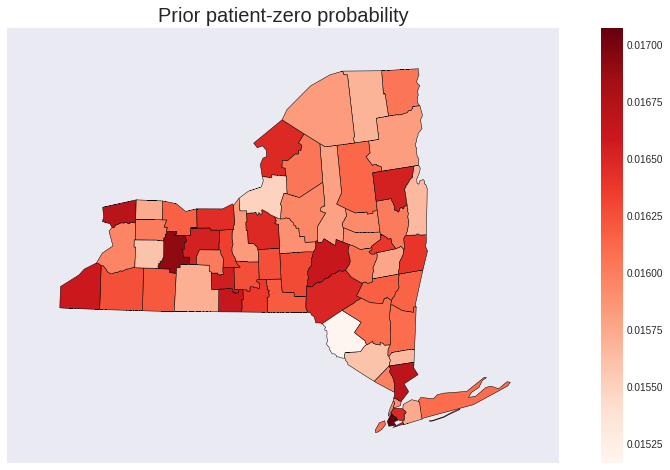

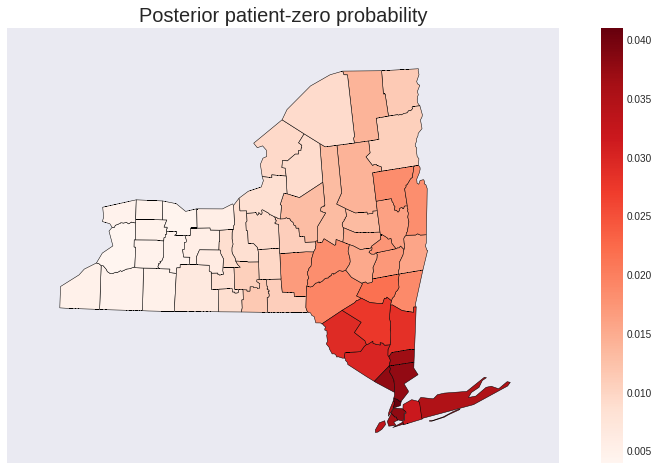

In [59]:
maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability', fontsize=20, choropleth=True,
       geojson='counties_ny.geojson')
maxentep.p0_map(prior_exposed_patch, M, weights = me_w, title = 'Posterior patient-zero probability', patch_names=patches, fontsize=20
      , choropleth=True, geojson='counties_ny.geojson')

Finding the top 5 most probable locations for the origin of outbreak:

In [60]:
sorted(zip(posterior_exposed_prob, patches), reverse=True)[:5]

[(0.04102200204916295, 'Bronx County'),
 (0.037970495264870244, 'Rockland County'),
 (0.037884444824697064, 'Queens County'),
 (0.03774769320738388, 'Westchester County'),
 (0.036705286691135604, 'Putnam County')]

## Theory 1
Basic reproductive number ($R_0$):

$ S \xrightarrow{\beta} E \xrightarrow{\eta} A \xrightarrow{\alpha} I \xrightarrow{\mu} R $

$R_0 = \frac{\beta S_0}{\alpha} +  \frac{\beta S_0}{\mu } $

$ t_{max} \sim \frac{log(S_0)}{\mu (R_0 -1)}$

In [61]:
# total_pop = np.sum(population)
# R0 = beta*total_pop*(1/alpha + 1/mu)

In [62]:
# t_max = np.log(total_pop)/mu/(R0-1)

In [63]:
# t_max